# Import all relevant packages

In [1]:
#import all 
%matplotlib inline
import matplotlib
import sys, os
from pandas.io.parsers import read_csv
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
import collections
import scipy
import itertools
#import floweaver
np.warnings.filterwarnings('ignore')
import pysam
import pyBigWig as bw
#%load_ext rpy2.ipython
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Read in dataframe

#### This is necessary for computing percentages and later allele counts. If these are already computed and saved, move down to 'load computed datasets'.

In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20200324_VAN2988_remap_BWAfilters-alleleCalling/'

In [3]:
df = pd.read_pickle(pathToData + '120hAA_miseq_remapped.pickle.gz')
df.head()

gastruloid                         C5A9                                    \
cell                               A2_1 A2_10 A2_100 A2_101 A2_102 A2_103   
chrom allele site      scar                                                 
1     None   12847807  WT           NaN   NaN    NaN    NaN    NaN    NaN   
             12847810  WT           NaN   NaN    NaN    NaN    NaN    NaN   
             12847812  WT           NaN   NaN    NaN    NaN    NaN    NaN   
             143473230 143473406.D  NaN   NaN    NaN    NaN    NaN    NaN   
             143473231 WT           NaN   NaN    NaN    NaN    NaN    NaN   

gastruloid                                                      ... C5F10  \
cell                               A2_104 A2_105 A2_106 A2_107  ... H2_90   
chrom allele site      scar                                     ...         
1     None   12847807  WT             NaN    NaN    NaN    NaN  ...   NaN   
             12847810  WT             NaN    NaN    NaN    NaN  ...   NaN   
             12847812  WT             NaN    NaN    NaN    NaN  ...   NaN   
             143473230 143473406.D    NaN    NaN    NaN    NaN  ...   NaN   
             143473231 WT             NaN    NaN    NaN    NaN  ...   NaN   

gastruloid                                                                    \
cell                               H2_91 H2_92 H2_93 H2_94 H2_95 H2_96 H2_97   
chrom allele site      scar                                                    
1     None   12847807  WT            NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             12847810  WT            NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             12847812  WT            NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             143473230 143473406.D   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             143473231 WT            NaN   NaN   NaN   NaN   NaN   NaN   NaN   

gastruloid                                      
cell                               H2_98 H2_99  
chrom allele site      scar                     
1     None   12847807  WT            NaN   NaN  
             12847810  WT            NaN   NaN  
             12847812  WT            NaN   NaN  
             143473230 143473406.D   NaN   NaN  
             143473231 WT            NaN   NaN  

[5 rows x 3062 columns]

In [4]:
sf = df.loc['12']

sf_129 = sf.loc['129S1_SvImJ']
sf_B6 = sf.loc['C57BL_6NJ']

sf_nonallelic = sf.loc['None']



# data quality plots

Here some basic checks are performed, such as total amount of reads per cell and amount of reads per chromosome. We amplify the scars in the IgH locus which is located on chomosome 12 (with some off-target sites caused by primer design). Amount of reads per chromosome are checked, for the whole dataset and for every gastruloid individually. Amount of reads per site are checked, separated by alleles.

#### Check the total amount of counts per cell
Green: all counts in total
Blue: all counts from chromosome 12 (IgH)

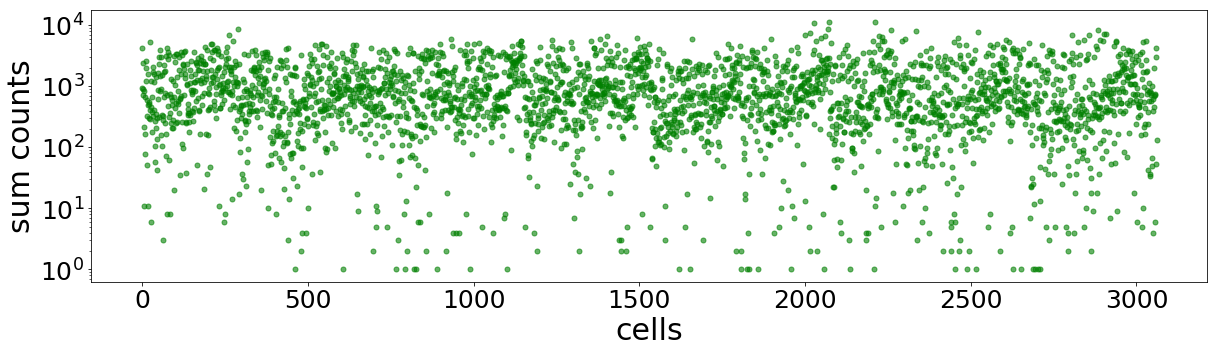

In [5]:
#all counts total
sums_cells = df.sum(axis=0)

plt.figure(figsize=(20,5))
ax = plt.gca()
ax.plot(range(len(sums_cells)), sums_cells, 'o', ms=5, color="green",alpha=0.6)
ax.set_yscale('log')
ax.set_xlabel('cells', fontsize=30); plt.ylabel('sum counts', fontsize=30)
ax.tick_params(labelsize=25)
plt.show()

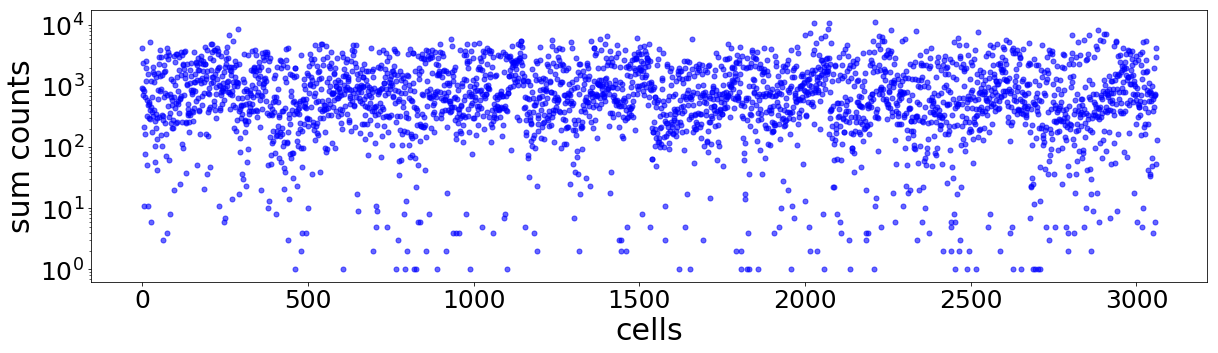

In [6]:
#all counts chr12
sums_cellsSF = sf.sum(axis=0)

plt.figure(figsize=(20,5))
ax = plt.gca()
ax.plot(range(len(sums_cellsSF)), sums_cellsSF, 'o', ms=5, color="blue",alpha=0.6)
ax.set_yscale('log')
ax.set_xlabel('cells', fontsize=30); plt.ylabel('sum counts', fontsize=30)
ax.tick_params(labelsize=25)
plt.show()

#### Check the total amount of counts per chromosome for all cells together

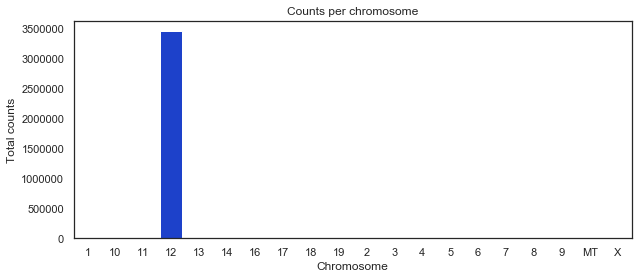

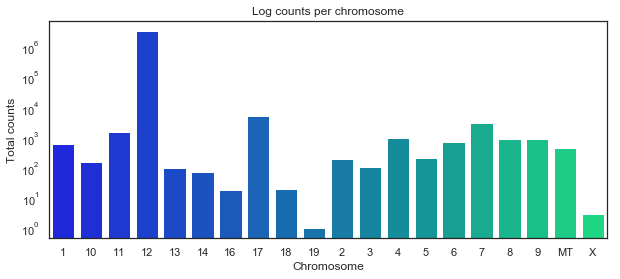

In [7]:
sns.set_context("talk", font_scale=5)

#Plot raw counts per chromosome
sums_cells = df.sum(axis=0, level=0)
countsPerChrom = sums_cells.sum(axis=1)
sns.set(style="white")
plt.figure(figsize=(10,4))
ax = sns.barplot(x=countsPerChrom.index, y=countsPerChrom,palette="winter")
ax.set(xlabel='Chromosome', ylabel='Total counts', title='Counts per chromosome')
plt.show()

sums_cells = df.sum(axis=0, level=0)
countsPerChrom = sums_cells.sum(axis=1)
sns.set(style="white")
plt.figure(figsize=(10,4))
ax = sns.barplot(x=countsPerChrom.index, y=countsPerChrom, log = 'y',palette="winter")
ax.set(xlabel='Chromosome', ylabel='Total counts',title='Log counts per chromosome')
plt.show()

#### Check the total amount of counts for each gRNA target site.
Green: Total amount of counts for each target site.
Orange: Amount of 129 reads for each target site.
Red: Amount of B6 reads for each target site.
Blue: Amount of reads not assigned to either allele for each target site.

In [8]:
#calculate total amount of reads per site
sums_cells_all = pd.DataFrame(sf.sum(axis=0, level=1).sum(axis=1))

#calculate total amount of reads per site, allele-specific
sums_cells_129 = pd.DataFrame(sf_129.sum(axis=0, level=0).sum(axis=1))
sums_cells_B6 = pd.DataFrame(sf_B6.sum(axis=0, level=0).sum(axis=1))
sums_cells_nonallelic = pd.DataFrame(sf_nonallelic.sum(axis=0, level=0).sum(axis=1))

#merge
countspersite = pd.concat([sums_cells_B6,sums_cells_129,
                                  sums_cells_nonallelic, sums_cells_all], axis=1, sort=True)
countspersite.columns = ['B6', '129', 'NA', 'all']
countspersite = countspersite.fillna(0)

#select only scar sites
selectedSites = countspersite.loc[['114682729','114708745','114723869',
                              '114740505','114746370','114788469', 
                              '114851287','114879985', '114896335',
                              '114914696']]



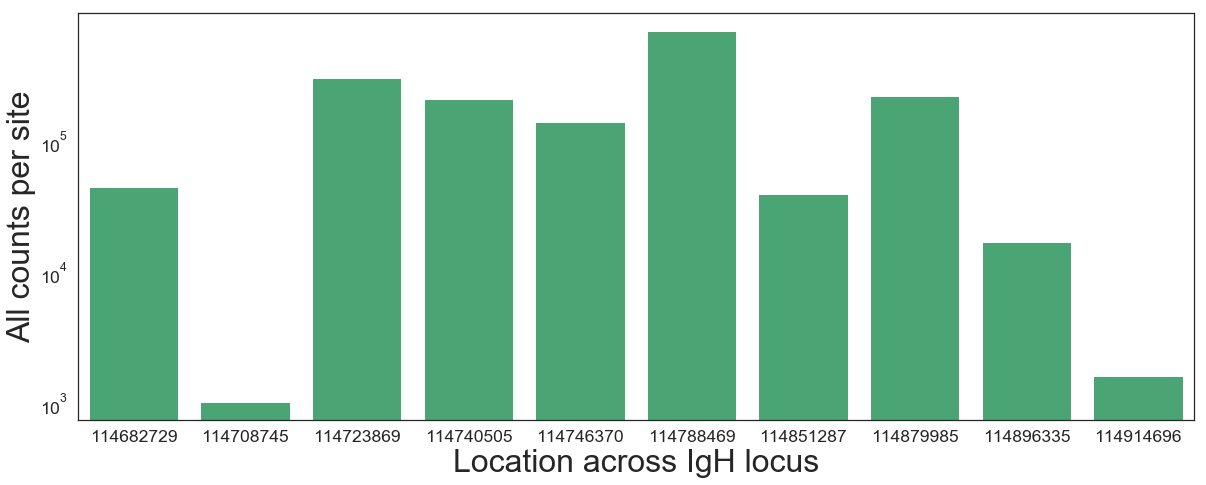

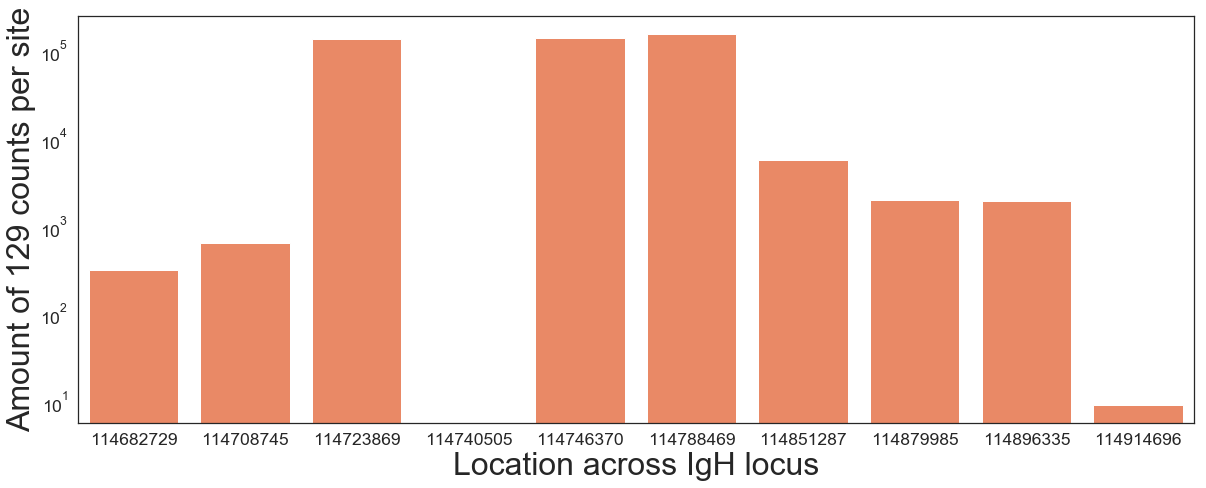

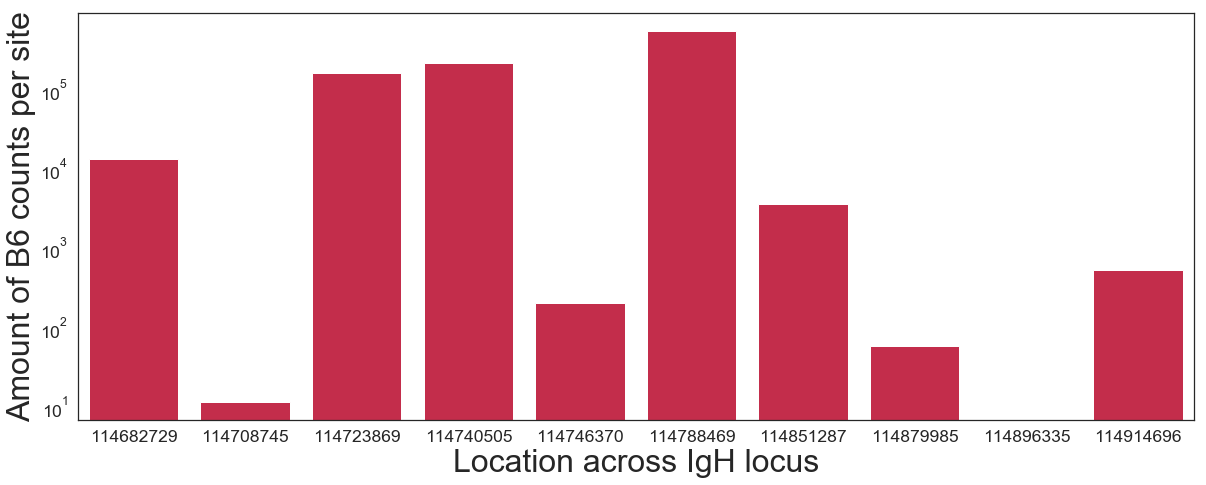

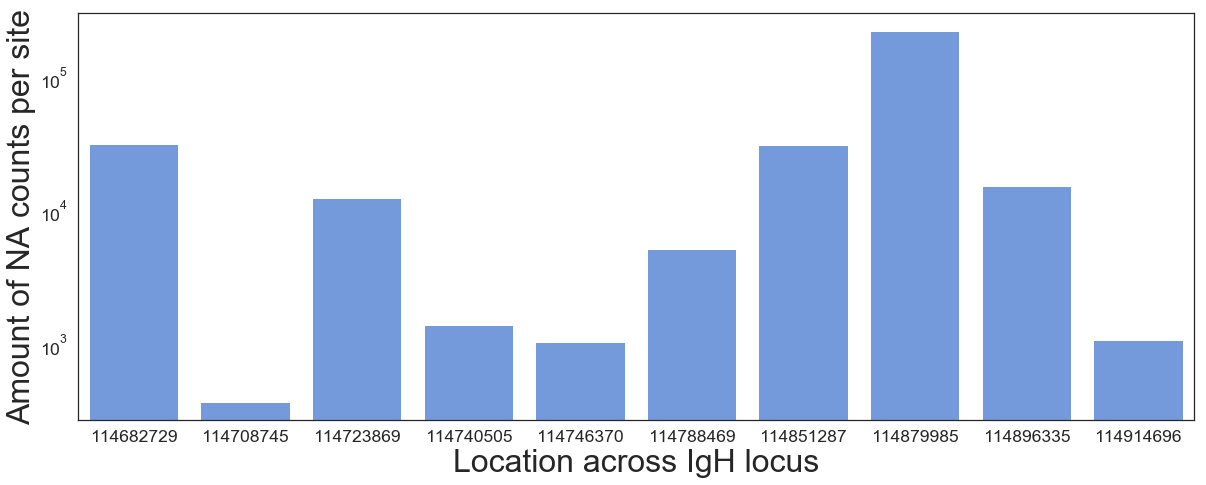

In [9]:
#plots
sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['all'], log='y', color='mediumseagreen')
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('All counts per site', fontsize=32)
ax.tick_params(labelsize=17.5)
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['129'], log='y', color='coral')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of 129 counts per site', fontsize=32)
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['B6'], log='y', color='crimson')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of B6 counts per site', fontsize=32)
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['NA'], log='y', color='cornflowerblue')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of NA counts per site', fontsize=32)
plt.show()

#### Total amount of reads per chromosome, for each gastruloid individually.

In [10]:
def plotChrCountsGastruloid (gastruloidname):
    sns.set(style="white", font_scale=1)
    plt.figure(figsize=(10,4))
    countsPerChrom = sums_cells[gastruloidname].sum(axis=1) 
    ax = sns.barplot(x=countsPerChrom.index, y=countsPerChrom, color='mediumblue')
    ax.set_title('Gastruloid' + str(gastruloidname))
    ax.set(xlabel='Chromosome', ylabel='Total counts')
    plt.show()

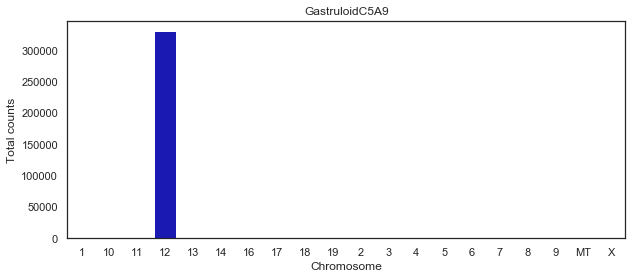

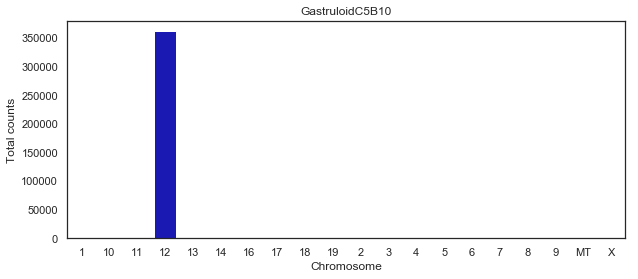

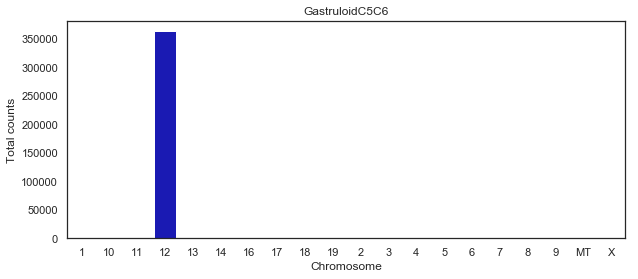

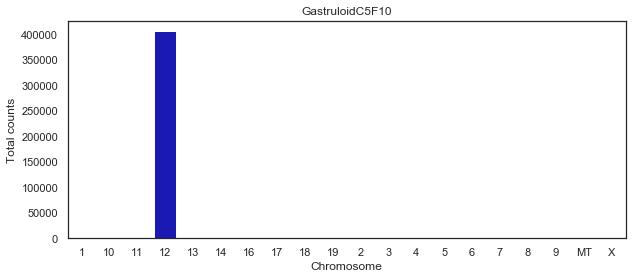

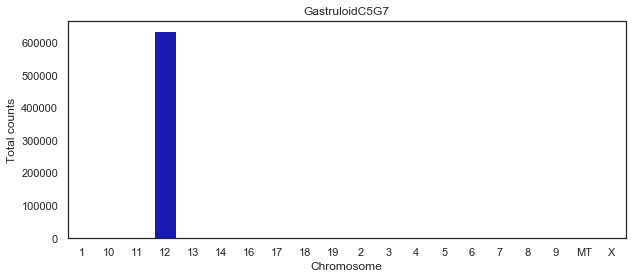

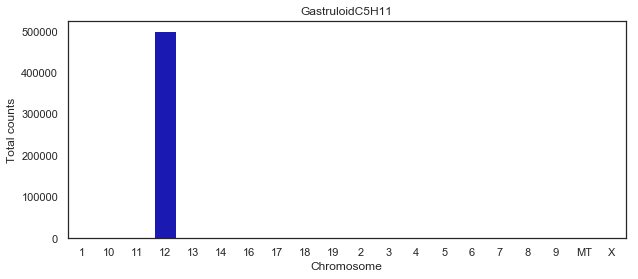

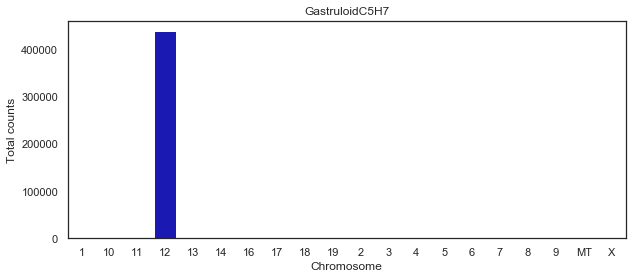

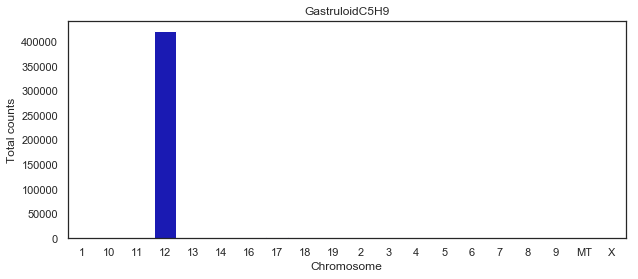

In [11]:
for gastruloid in df.columns.levels[0]:
    plotChrCountsGastruloid(gastruloid)

# Calculate percentages per allele for chromosome 12

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

here we also filter on the amount of reads per cell/site/allele by continuing when totalReadsForThisSite < 4.
To be considered for conversion to percentages, a cell/site/allele must contain 4 or more reads.

In [ ]:
sitesB6 = []
sites129 = []
sitesNA = []
for (allele,site,scar) in sf.index:
    if allele == 'C57BL_6NJ':
        if site != 'None':
            if site not in sitesB6:
                sitesB6.append(site)
    if allele == '129S1_SvImJ':
        if site != 'None':
            if site not in sites129:
                sites129.append(site)
    if allele != 'C57BL_6NJ' and allele != '129S1_SvImJ' and allele !='129S1_SvImJ,C57BL_6NJ' :
        if site != 'None':
            if site not in sitesNA:
                sitesNA.append(site)

In [ ]:
#129
sf_129 = sf_129.fillna(0)
cellToSiteToScarPercentage129 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for gastruloid, cell in sf_129.columns:
    for site in sites129:
        if len(sf_129.loc[site]) < 4:
            continue
        totalReadsForThisSite = sf_129.loc[site, (gastruloid, cell)].sum()
        if totalReadsForThisSite < 4:
            continue
        for scar, amountOfReads in sf_129.loc[site,(gastruloid, cell)].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            if percentage > 5:
                cellToSiteToScarPercentage129[(gastruloid,cell)][int(site)][scar] += percentage

percentagesChrom12 = collections.defaultdict(dict) # (cell, gastruloid)->(site,scar)-> value (.. ,1,2)

for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentage129.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(10):
            percentagesChrom12[(cell,gastruloid)][(site,scar)] = percentage

percentagesChr12_129 = pd.DataFrame(percentagesChrom12)

In [ ]:
#B6
sf_B6 = sf_B6.fillna(0)
cellToSiteToScarPercentageB6 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for gastruloid, cell in sf_B6.columns:
    for site in sitesB6:
        if len(sf_B6.loc[site]) < 4:
            continue
        totalReadsForThisSite = sf_B6.loc[site, (gastruloid, cell)].sum()
        if totalReadsForThisSite < 4:
            continue
        for scar, amountOfReads in sf_B6.loc[site,(gastruloid, cell)].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            if percentage > 5:
                cellToSiteToScarPercentageB6[(gastruloid,cell)][int(site)][scar] += percentage

percentagesChr12B6 = collections.defaultdict(dict) # (cell, gastruloid)->(site,scar)-> value (.. ,1,2)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentageB6.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(10):
            percentagesChr12B6[(cell,gastruloid)][(site,scar)] = percentage

percentagesChr12_B6 = pd.DataFrame(percentagesChr12B6)

In [ ]:
#nonallelic
sf_nonallelic = sf_nonallelic.fillna(0)                
cellToSiteToScarPercentageNA = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for gastruloid, cell in sf_nonallelic.columns:
    for site in sitesNA:
        if len(sf_nonallelic.loc[site]) < 4:
            continue
        totalReadsForThisSite = sf_nonallelic.loc[site, (gastruloid, cell)].sum()
        if totalReadsForThisSite < 4:
            continue
        for scar, amountOfReads in sf_nonallelic.loc[site,(gastruloid, cell)].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            if percentage > 5:
                cellToSiteToScarPercentageNA[(gastruloid,cell)][int(site)][scar] += percentage

percentagesChr12NA = collections.defaultdict(dict) # (cell, gastruloid)->(site,scar)-> value (.. ,1,2)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentageNA.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(10):
            percentagesChr12NA[(cell,gastruloid)][(site,scar)] = percentage

percentagesChr12_NA = pd.DataFrame(percentagesChr12NA)

In [ ]:
#to save dataframes
percentagesChr12_129.to_pickle(pathToData + 'unfiltered_120hAA_dataFramepercentagesChr12_129.pickle.gz')
percentagesChr12_B6.to_pickle(pathToData + 'unfiltered_120hAA_dataFramepercentagesChr12_B6.pickle.gz')
percentagesChr12_NA.to_pickle(pathToData + 'unfiltered_120hAA_dataFramepercentagesChr12_NA.pickle.gz')

# Converting to allele counts

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

In [ ]:
#For 129:
alleleCountsChr12_129 = collections.defaultdict(dict)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentage129.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(2):
            if percentage > 55: 
                alleleCountsChr12_129[(cell,gastruloid)][(site,scar)] = 1

alleleCountsChr12_129PD = pd.DataFrame(alleleCountsChr12_129)

In [ ]:
# For B6:
alleleCountsChr12_B6 = collections.defaultdict(dict)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentageB6.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(2):
            if percentage > 55: 
                alleleCountsChr12_B6[(cell,gastruloid)][(site,scar)] = 1

alleleCountsChr12_B6PD = pd.DataFrame(alleleCountsChr12_B6)

In [ ]:
#'allelecounts' non-allelic
alleleCountsChr12_NA = collections.defaultdict(dict)
for (cell, gastruloid), allSitesForThisCell in cellToSiteToScarPercentageNA.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(2):
            if percentage > 55: 
                alleleCountsChr12_NA[(cell,gastruloid)][(site,scar)] = 2
            elif percentage > 30 and percentage < 55:
                alleleCountsChr12_NA[(cell,gastruloid)][(site,scar)] = 1

alleleCountsChr12_NAPD = pd.DataFrame(alleleCountsChr12_NA)        

In [ ]:
#to save dataframes
alleleCountsChr12_129PD.to_pickle(pathToData + 'unfiltered_120hAA_dataFrameAlleleCountsChr12_129.pickle.gz')
alleleCountsChr12_B6PD.to_pickle(pathToData + 'unfiltered_120hAA_dataFrameAlleleCountsChr12_B6.pickle.gz')
alleleCountsChr12_NAPD.to_pickle(pathToData + 'unfiltered_120hAA_dataFrameAlleleCountsChr12_NA.pickle.gz')

# Make dataframes for sparse distance matrix (IWSS) clustering

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

In [ ]:
targetsites = [114682729, 114708745, 114723869, 114740505,114746370, 114788469, 114843748, 114851287,
          114879985,114896335,114910108,114914696]

In [ ]:
targetsites129 = []
targetsitesB6 = []
targetsitesNA = []
for site in targetsites:
    for index in alleleCountsChr12_129PD.index.levels[0]:
        if site == index:
            targetsites129.append(site)
    for index in alleleCountsChr12_B6PD.index.levels[0]:
        if site == index:
            targetsitesB6.append(site)
    for index in alleleCountsChr12_NAPD.index.levels[0]:
        if site == index:
            targetsitesNA.append(site)

In [ ]:
allelecounts129_ts = alleleCountsChr12_129PD.loc[targetsites129]
allelecountsB6_ts = alleleCountsChr12_B6PD.loc[targetsitesB6]
allelecountsNA_ts = alleleCountsChr12_NAPD.loc[targetsitesNA]

In [ ]:
allelecountsNA_ts.index = ['NA_' + str(site) for site in allelecountsNA_ts.index]
allelecountsB6_ts.index = ['B6_' + str(site) for site in allelecountsB6_ts.index]
allelecounts129_ts.index = ['129_' + str(site) for site in allelecounts129_ts.index]

In [ ]:
dfs = [allelecountsNA_ts,allelecountsB6_ts,allelecounts129_ts]
all_allelecounts_fordistancecalc = pd.concat(dfs)

In [ ]:
#to save 
all_allelecounts_fordistancecalc.to_pickle(pathToData + 'unfiltered_120hAA_all_allelecounts_fordistancecalc.pickle.gz')
allelecountsNA_ts.to_pickle(pathToData + 'unfiltered_120hAA_allelecountsNA_ts.pickle.gz')
allelecountsB6_ts.to_pickle(pathToData + 'unfiltered_120hAA_allelecountsB6_ts.pickle.gz')
allelecounts129_ts.to_pickle(pathToData + 'unfiltered_120hAA_allelecounts129_ts.pickle.gz')

# Making 'heatmap' dataframes for Buys' heatmap plotting

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

In [ ]:
# for 129
alleleCountsChr12_129PD
heatmapAllele_129 = alleleCountsChr12_129PD.copy()
heatmapAlleleCounts_129 = collections.defaultdict(dict)
for (gastruloid, cell), allSitesForThisCell in heatmapAllele_129.items():
    for (site, scar), allelecounts in allSitesForThisCell.items():
        if allelecounts == 1.0:
            heatmapAlleleCounts_129[('129, ' + str(site))][(gastruloid,cell)] = scar
            
heatmapAlleleCounts_129Pd = pd.DataFrame(heatmapAlleleCounts_129)

In [ ]:
# for B6
alleleCountsChr12_B6PD
heatmapAlleleCounts_B6 = collections.defaultdict(dict)
for (gastruloid, cell), allSitesForThisCell in alleleCountsChr12_B6PD.items():
    for (site, scar), allelecounts in allSitesForThisCell.items():
        if allelecounts == 1.0:
            heatmapAlleleCounts_B6[('B6, ' + str(site))][(gastruloid,cell)] = scar

heatmapAlleleCounts_B6PD = pd.DataFrame(heatmapAlleleCounts_B6)

In [ ]:
#nonallelic
heatmap_nonallelic = collections.defaultdict(dict)

for (gastruloid, cell), allSitesForThisCell in alleleCountsChr12_NAPD.items():
    for (site, scar), allelecounts in allSitesForThisCell.items():
        if allelecounts == 2.0:
            heatmap_nonallelic[('nonallelic, ' + str(site))][(gastruloid,cell)] = scar
            
heatmap_nonallelicPD = pd.DataFrame(heatmap_nonallelic)

In [ ]:
dfs_all = [heatmapAlleleCounts_129Pd,heatmapAlleleCounts_B6PD,heatmap_nonallelicPD]
heatmap = dfs_all[0].join(dfs_all[1:],how='outer')

In [ ]:
heatmapAlleleCounts_129Pd.to_pickle(pathToData + 'unfiltered_120hAA_dataframeForHeatmap_All_129.pickle.gz')
heatmapAlleleCounts_B6PD.to_pickle(pathToData + 'unfiltered_120hAA_dataframeForHeatmap_All_B6.pickle.gz')
heatmap_nonallelicPD.to_pickle(pathToData + 'unfiltered_120hAA_dataframeForHeatmap_All_nonallelic.pickle.gz')
heatmap.to_pickle(pathToData + 'unfiltered_120hAA_dataframeForHeatmap_All.pickle.gz')

# Load computed datasets

#### Here you can load all precomputed datasets.

In [12]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20200227_VAN2988_OUD3695_remap_snakemake/'

In [13]:
#to load dataframes containing all calculated percentages again
percentagesChr12_129 = pd.read_pickle(pathToData + '120hAA_dataFramepercentagesChr12_129.pickle.gz')
percentagesChr12_B6 = pd.read_pickle(pathToData + '120hAA_dataFramepercentagesChr12_B6.pickle.gz')
percentagesChr12_NA = pd.read_pickle(pathToData + '120hAA_dataFramepercentagesChr12_NA.pickle.gz')

In [14]:
#to load dataframes containing all allele counts again
alleleCountsChr12_129PD = pd.read_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_129.pickle.gz')
alleleCountsChr12_B6PD = pd.read_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_B6.pickle.gz')
alleleCountsChr12_NAPD = pd.read_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_NA.pickle.gz')

In [15]:
#to load dataframes for distance calculation again
all_allelecounts_fordistancecalc = pd.read_pickle(pathToData + '120hAA_all_allelecounts_fordistancecalc.pickle.gz')
allelecountsNA_ts = pd.read_pickle(pathToData + '120hAA_allelecountsNA_ts.pickle.gz')
allelecountsB6_ts = pd.read_pickle(pathToData + '120hAA_allelecountsB6_ts.pickle.gz')
allelecounts129_ts = pd.read_pickle(pathToData + '120hAA_allelecounts129_ts.pickle.gz')

In [16]:
#to load dataframes for Buys' heatmap calculation again
heatmap_129 = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All_129.pickle.gz')
heatmap_129.index.names = ['gastruloid', 'cell']
heatmap_B6 = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All_B6.pickle.gz')
heatmap_B6.index.names = ['gastruloid', 'cell']
heatmap_NA = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All_nonallelic.pickle.gz')
heatmap_NA.index.names = ['gastruloid', 'cell']

heatmap = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All.pickle.gz')
heatmap.index.names = ['gastruloid', 'cell']

In [17]:
cols=["black", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#006FA6", "#A30059", "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80","#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100", "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09","#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66","#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00","#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700","#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329","#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C","#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800","#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51","#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58","#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D","#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176","#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5","#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4","#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01","#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966","#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0","#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C","#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868","#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183","#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433","#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F","#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E","#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F","#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00","#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66","#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25","#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B", "#1E2324", "#DEC9B2", "#9D4948","#85ABB4", "#342142", "#D09685", "#A4ACAC", "#00FFFF", "#AE9C86", "#742A33", "#0E72C5","#AFD8EC", "#C064B9", "#91028C", "#FEEDBF", "#FFB789", "#9CB8E4", "#AFFFD1", "#2A364C","#4F4A43", "#647095", "#34BBFF", "#807781", "#920003", "#B3A5A7", "#018615", "#F1FFC8","#976F5C", "#FF3BC1", "#FF5F6B", "#077D84", "#F56D93", "#5771DA", "#4E1E2A", "#830055","#02D346", "#BE452D", "#00905E", "#BE0028", "#6E96E3", "#007699", "#FEC96D", "#9C6A7D","#3FA1B8", "#893DE3", "#79B4D6", "#7FD4D9", "#6751BB", "#B28D2D", "#E27A05", "#DD9CB8","#AABC7A", "#980034", "#561A02", "#8F7F00", "#635000", "#CD7DAE", "#8A5E2D", "#FFB3E1","#6B6466", "#C6D300", "#0100E2", "#88EC69", "#8FCCBE", "#21001C", "#511F4D", "#E3F6E3","#FF8EB1", "#6B4F29", "#A37F46", "#6A5950", "#1F2A1A", "#04784D", "#101835", "#E6E0D0","#FF74FE", "#00A45F", "#8F5DF8", "#4B0059", "#412F23", "#D8939E", "#DB9D72", "#604143","#B5BACE", "#989EB7", "#D2C4DB", "#A587AF", "#77D796", "#7F8C94", "#FF9B03", "#555196","#31DDAE", "#74B671", "#802647", "#2A373F", "#014A68", "#696628", "#4C7B6D", "#002C27","#7A4522", "#3B5859", "#E5D381", "#FFF3FF", "#679FA0", "#261300", "#2C5742", "#9131AF","#AF5D88", "#C7706A", "#61AB1F", "#8CF2D4", "#C5D9B8", "#9FFFFB", "#BF45CC", "#493941","#863B60", "#B90076", "#003177", "#C582D2", "#C1B394", "#602B70", "#887868", "#BABFB0","#030012", "#D1ACFE", "#7FDEFE", "#4B5C71", "#A3A097", "#E66D53", "#637B5D", "#92BEA5","#00F8B3", "#BEDDFF", "#3DB5A7", "#DD3248", "#B6E4DE", "#427745", "#598C5A", "#B94C59","#8181D5", "#94888B", "#FED6BD", "#536D31", "#6EFF92", "#E4E8FF", "#20E200", "#FFD0F2","#4C83A1", "#BD7322", "#915C4E", "#8C4787", "#025117", "#A2AA45", "#2D1B21", "#A9DDB0","#FF4F78", "#528500", "#009A2E", "#17FCE4", "#71555A", "#525D82", "#00195A", "#967874","#555558", "#0B212C", "#1E202B", "#EFBFC4", "#6F9755", "#6F7586", "#501D1D", "#372D00","#741D16", "#5EB393", "#B5B400", "#DD4A38", "#363DFF", "#AD6552", "#6635AF", "#836BBA","#98AA7F", "#464836", "#322C3E", "#7CB9BA", "#5B6965", "#707D3D", "#7A001D", "#6E4636","#443A38", "#AE81FF", "#489079", "#897334", "#009087", "#DA713C", "#361618", "#FF6F01","#006679", "#370E77", "#4B3A83", "#C9E2E6", "#C44170", "#FF4526", "#73BE54", "#C4DF72","#ADFF60", "#00447D", "#DCCEC9", "#BD9479", "#656E5B", "#EC5200", "#FF6EC2", "#7A617E","#DDAEA2", "#77837F", "#A53327", "#608EFF", "#B599D7", "#A50149", "#4E0025", "#C9B1A9","#03919A", "#1B2A25", "#E500F1", "#982E0B", "#B67180", "#E05859", "#006039", "#578F9B","#305230", "#CE934C", "#B3C2BE", "#C0BAC0", "#B506D3", "#170C10", "#4C534F", "#224451","#3E4141", "#78726D", "#B6602B", "#200441", "#DDB588", "#497200", "#C5AAB6", "#033C61","#71B2F5", "#A9E088", "#4979B0", "#A2C3DF", "#784149", "#2D2B17", "#3E0E2F", "#57344C","#0091BE", "#E451D1", "#4B4B6A", "#5C011A", "#7C8060", "#FF9491", "#4C325D", "#005C8B","#E5FDA4", "#68D1B6", "#032641", "#140023", "#8683A9", "#CFFF00", "#A72C3E", "#34475A","#B1BB9A", "#B4A04F", "#8D918E", "#A168A6", "#813D3A", "#425218", "#DA8386", "#776133","#563930", "#8498AE", "#90C1D3", "#B5666B", "#9B585E", "#856465", "#AD7C90", "#E2BC00","#E3AAE0", "#B2C2FE", "#FD0039", "#009B75", "#FFF46D", "#E87EAC", "#DFE3E6", "#848590","#AA9297", "#83A193", "#577977", "#3E7158", "#C64289", "#EA0072", "#C4A8CB", "#55C899","#E78FCF", "#004547", "#F6E2E3", "#966716", "#378FDB", "#435E6A", "#DA0004", "#1B000F","#5B9C8F", "#6E2B52", "#011115", "#E3E8C4", "#AE3B85", "#EA1CA9", "#FF9E6B", "#457D8B","#92678B", "#00CDBB", "#9CCC04", "#002E38", "#96C57F", "#CFF6B4", "#492818", "#766E52","#20370E", "#E3D19F", "#2E3C30", "#B2EACE", "#F3BDA4", "#A24E3D", "#976FD9", "#8C9FA8","#7C2B73", "#4E5F37", "#5D5462", "#90956F", "#6AA776", "#DBCBF6", "#DA71FF", "#987C95","#52323C", "#BB3C42", "#584D39", "#4FC15F", "#A2B9C1", "#79DB21", "#1D5958", "#BD744E","#160B00", "#20221A", "#6B8295", "#00E0E4", "#102401", "#1B782A", "#DAA9B5", "#B0415D","#859253", "#97A094", "#06E3C4", "#47688C", "#7C6755", "#075C00", "#7560D5", "#7D9F00","#C36D96", "#4D913E", "#5F4276", "#FCE4C8", "#303052", "#4F381B", "#E5A532", "#706690","#AA9A92", "#237363", "#73013E", "#FF9079", "#A79A74", "#029BDB", "#FF0169", "#C7D2E7","#CA8869", "#80FFCD", "#BB1F69", "#90B0AB", "#7D74A9", "#FCC7DB", "#99375B", "#00AB4D","#ABAED1", "#BE9D91", "#E6E5A7", "#332C22", "#DD587B", "#F5FFF7", "#5D3033", "#6D3800","#FF0020", "#B57BB3", "#D7FFE6", "#C535A9", "#260009", "#6A8781", "#A8ABB4", "#D45262","#794B61", "#4621B2", "#8DA4DB", "#C7C890", "#6FE9AD", "#A243A7", "#B2B081", "#181B00","#286154", "#4CA43B", "#6A9573", "#A8441D", "#5C727B", "#738671", "#D0CFCB", "#897B77","#1F3F22", "#4145A7", "#DA9894", "#A1757A", "#63243C", "#ADAAFF", "#00CDE2", "#DDBC62","#698EB1", "#208462", "#00B7E0", "#614A44", "#9BBB57", "#7A5C54", "#857A50", "#766B7E","#014833", "#FF8347", "#7A8EBA", "#274740", "#946444", "#EBD8E6", "#646241", "#373917","#6AD450", "#81817B", "#D499E3", "#979440", "#011A12", "#526554", "#B5885C", "#A499A5","#03AD89", "#B3008B", "#E3C4B5", "#96531F", "#867175", "#74569E", "#617D9F", "#E70452","#067EAF", "#A697B6", "#B787A8", "#9CFF93", "#311D19", "#3A9459", "#6E746E", "#B0C5AE","#84EDF7", "#ED3488", "#754C78", "#384644", "#C7847B", "#00B6C5", "#7FA670", "#C1AF9E","#2A7FFF", "#72A58C", "#FFC07F", "#9DEBDD", "#D97C8E", "#7E7C93", "#62E674", "#B5639E","#FFA861", "#C2A580", "#8D9C83", "#B70546", "#372B2E", "#0098FF", "#985975", "#20204C","#FF6C60", "#445083", "#8502AA", "#72361F", "#9676A3", "#484449", "#CED6C2", "#3B164A","#CCA763", "#2C7F77", "#02227B", "#A37E6F", "#CDE6DC", "#CDFFFB", "#BE811A", "#F77183","#EDE6E2", "#CDC6B4", "#FFE09E", "#3A7271", "#FF7B59", "#4E4E01", "#4AC684", "#8BC891","#BC8A96", "#CF6353", "#DCDE5C", "#5EAADD", "#F6A0AD", "#E269AA", "#A3DAE4", "#436E83","#002E17", "#ECFBFF", "#A1C2B6", "#50003F", "#71695B", "#67C4BB", "#536EFF", "#5D5A48","#890039", "#969381", "#371521", "#5E4665", "#AA62C3", "#8D6F81", "#2C6135", "#410601","#564620", "#E69034", "#6DA6BD", "#E58E56", "#E3A68B", "#48B176", "#D27D67", "#B5B268","#7F8427", "#FF84E6", "#435740", "#EAE408", "#F4F5FF", "#325800", "#4B6BA5", "#ADCEFF","#9B8ACC", "#885138", "#5875C1", "#7E7311", "#FEA5CA", "#9F8B5B", "#A55B54", "#89006A","#AF756F", "#2A2000", "#7499A1", "#FFB550", "#00011E", "#D1511C", "#688151", "#BC908A","#78C8EB", "#8502FF", "#483D30", "#C42221", "#5EA7FF", "#785715", "#0CEA91", "#FFFAED","#B3AF9D", "#3E3D52", "#5A9BC2", "#9C2F90", "#8D5700", "#ADD79C", "#00768B", "#337D00","#C59700", "#3156DC", "#944575", "#ECFFDC", "#D24CB2", "#97703C", "#4C257F", "#9E0366","#88FFEC", "#B56481", "#396D2B", "#56735F", "#988376", "#9BB195", "#A9795C", "#E4C5D3","#9F4F67", "#1E2B39", "#664327", "#AFCE78", "#322EDF", "#86B487", "#C23000", "#ABE86B","#96656D", "#250E35", "#A60019", "#0080CF", "#CAEFFF", "#323F61", "#A449DC", "#6A9D3B","#FF5AE4", "#636A01", "#D16CDA", "#736060", "#FFBAAD", "#D369B4", "#FFDED6", "#6C6D74","#927D5E", "#845D70", "#5B62C1", "#2F4A36", "#E45F35", "#FF3B53", "#AC84DD", "#762988","#70EC98", "#408543", "#2C3533", "#2E182D", "#323925", "#19181B", "#2F2E2C", "#023C32","#9B9EE2", "#58AFAD", "#5C424D", "#7AC5A6", "#685D75", "#B9BCBD", "#834357", "#1A7B42","#2E57AA", "#E55199", "#316E47", "#CD00C5", "#6A004D", "#7FBBEC", "#F35691", "#D7C54A","#62ACB7", "#CBA1BC", "#A28A9A", "#6C3F3B", "#FFE47D", "#DCBAE3", "#5F816D", "#3A404A","#7DBF32", "#E6ECDC", "#852C19", "#285366", "#B8CB9C", "#0E0D00", "#4B5D56", "#6B543F","#E27172", "#0568EC", "#2EB500", "#D21656", "#EFAFFF", "#682021", "#2D2011", "#DA4CFF","#70968E", "#FF7B7D", "#4A1930", "#E8C282", "#E7DBBC", "#A68486", "#1F263C", "#36574E","#52CE79", "#ADAAA9", "#8A9F45", "#6542D2", "#00FB8C", "#5D697B", "#CCD27F", "#94A5A1","#790229", "#E383E6", "#7EA4C1", "#4E4452", "#4B2C00", "#620B70", "#314C1E", "#874AA6","#E30091", "#66460A", "#EB9A8B", "#EAC3A3", "#98EAB3", "#AB9180", "#B8552F", "#1A2B2F","#94DDC5", "#9D8C76", "#9C8333", "#94A9C9", "#392935", "#8C675E", "#CCE93A", "#917100","#01400B", "#449896", "#1CA370", "#E08DA7", "#8B4A4E", "#667776", "#4692AD", "#67BDA8","#69255C", "#D3BFFF", "#4A5132", "#7E9285", "#77733C", "#E7A0CC", "#51A288", "#2C656A","#4D5C5E", "#C9403A", "#DDD7F3", "#005844", "#B4A200", "#488F69", "#858182", "#D4E9B9","#3D7397", "#CAE8CE", "#D60034", "#AA6746", "#9E5585", "#BA6200"]

#  Plotting percentages

Plot percentages of scars per cell for one site and all cells of one gastruloid

In [ ]:
df.loc['12','129S1_SvImJ','114682729']['C5F10'].sum(axis=1)

In [ ]:
cols=["black", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#006FA6", "#A30059", "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80","#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100", "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09","#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66","#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00","#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700","#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329","#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C","#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800","#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51","#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58","#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D","#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176","#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5","#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4","#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01","#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966","#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0","#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C","#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868","#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183","#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433","#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F","#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E","#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F","#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00","#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66","#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25","#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B", "#1E2324", "#DEC9B2", "#9D4948","#85ABB4", "#342142", "#D09685", "#A4ACAC", "#00FFFF", "#AE9C86", "#742A33", "#0E72C5","#AFD8EC", "#C064B9", "#91028C", "#FEEDBF", "#FFB789", "#9CB8E4", "#AFFFD1", "#2A364C","#4F4A43", "#647095", "#34BBFF", "#807781", "#920003", "#B3A5A7", "#018615", "#F1FFC8","#976F5C", "#FF3BC1", "#FF5F6B", "#077D84", "#F56D93", "#5771DA", "#4E1E2A", "#830055","#02D346", "#BE452D", "#00905E", "#BE0028", "#6E96E3", "#007699", "#FEC96D", "#9C6A7D","#3FA1B8", "#893DE3", "#79B4D6", "#7FD4D9", "#6751BB", "#B28D2D", "#E27A05", "#DD9CB8","#AABC7A", "#980034", "#561A02", "#8F7F00", "#635000", "#CD7DAE", "#8A5E2D", "#FFB3E1","#6B6466", "#C6D300", "#0100E2", "#88EC69", "#8FCCBE", "#21001C", "#511F4D", "#E3F6E3","#FF8EB1", "#6B4F29", "#A37F46", "#6A5950", "#1F2A1A", "#04784D", "#101835", "#E6E0D0","#FF74FE", "#00A45F", "#8F5DF8", "#4B0059", "#412F23", "#D8939E", "#DB9D72", "#604143","#B5BACE", "#989EB7", "#D2C4DB", "#A587AF", "#77D796", "#7F8C94", "#FF9B03", "#555196","#31DDAE", "#74B671", "#802647", "#2A373F", "#014A68", "#696628", "#4C7B6D", "#002C27","#7A4522", "#3B5859", "#E5D381", "#FFF3FF", "#679FA0", "#261300", "#2C5742", "#9131AF","#AF5D88", "#C7706A", "#61AB1F", "#8CF2D4", "#C5D9B8", "#9FFFFB", "#BF45CC", "#493941","#863B60", "#B90076", "#003177", "#C582D2", "#C1B394", "#602B70", "#887868", "#BABFB0","#030012", "#D1ACFE", "#7FDEFE", "#4B5C71", "#A3A097", "#E66D53", "#637B5D", "#92BEA5","#00F8B3", "#BEDDFF", "#3DB5A7", "#DD3248", "#B6E4DE", "#427745", "#598C5A", "#B94C59","#8181D5", "#94888B", "#FED6BD", "#536D31", "#6EFF92", "#E4E8FF", "#20E200", "#FFD0F2","#4C83A1", "#BD7322", "#915C4E", "#8C4787", "#025117", "#A2AA45", "#2D1B21", "#A9DDB0","#FF4F78", "#528500", "#009A2E", "#17FCE4", "#71555A", "#525D82", "#00195A", "#967874","#555558", "#0B212C", "#1E202B", "#EFBFC4", "#6F9755", "#6F7586", "#501D1D", "#372D00","#741D16", "#5EB393", "#B5B400", "#DD4A38", "#363DFF", "#AD6552", "#6635AF", "#836BBA","#98AA7F", "#464836", "#322C3E", "#7CB9BA", "#5B6965", "#707D3D", "#7A001D", "#6E4636","#443A38", "#AE81FF", "#489079", "#897334", "#009087", "#DA713C", "#361618", "#FF6F01","#006679", "#370E77", "#4B3A83", "#C9E2E6", "#C44170", "#FF4526", "#73BE54", "#C4DF72","#ADFF60", "#00447D", "#DCCEC9", "#BD9479", "#656E5B", "#EC5200", "#FF6EC2", "#7A617E","#DDAEA2", "#77837F", "#A53327", "#608EFF", "#B599D7", "#A50149", "#4E0025", "#C9B1A9","#03919A", "#1B2A25", "#E500F1", "#982E0B", "#B67180", "#E05859", "#006039", "#578F9B","#305230", "#CE934C", "#B3C2BE", "#C0BAC0", "#B506D3", "#170C10", "#4C534F", "#224451","#3E4141", "#78726D", "#B6602B", "#200441", "#DDB588", "#497200", "#C5AAB6", "#033C61","#71B2F5", "#A9E088", "#4979B0", "#A2C3DF", "#784149", "#2D2B17", "#3E0E2F", "#57344C","#0091BE", "#E451D1", "#4B4B6A", "#5C011A", "#7C8060", "#FF9491", "#4C325D", "#005C8B","#E5FDA4", "#68D1B6", "#032641", "#140023", "#8683A9", "#CFFF00", "#A72C3E", "#34475A","#B1BB9A", "#B4A04F", "#8D918E", "#A168A6", "#813D3A", "#425218", "#DA8386", "#776133","#563930", "#8498AE", "#90C1D3", "#B5666B", "#9B585E", "#856465", "#AD7C90", "#E2BC00","#E3AAE0", "#B2C2FE", "#FD0039", "#009B75", "#FFF46D", "#E87EAC", "#DFE3E6", "#848590","#AA9297", "#83A193", "#577977", "#3E7158", "#C64289", "#EA0072", "#C4A8CB", "#55C899","#E78FCF", "#004547", "#F6E2E3", "#966716", "#378FDB", "#435E6A", "#DA0004", "#1B000F","#5B9C8F", "#6E2B52", "#011115", "#E3E8C4", "#AE3B85", "#EA1CA9", "#FF9E6B", "#457D8B","#92678B", "#00CDBB", "#9CCC04", "#002E38", "#96C57F", "#CFF6B4", "#492818", "#766E52","#20370E", "#E3D19F", "#2E3C30", "#B2EACE", "#F3BDA4", "#A24E3D", "#976FD9", "#8C9FA8","#7C2B73", "#4E5F37", "#5D5462", "#90956F", "#6AA776", "#DBCBF6", "#DA71FF", "#987C95","#52323C", "#BB3C42", "#584D39", "#4FC15F", "#A2B9C1", "#79DB21", "#1D5958", "#BD744E","#160B00", "#20221A", "#6B8295", "#00E0E4", "#102401", "#1B782A", "#DAA9B5", "#B0415D","#859253", "#97A094", "#06E3C4", "#47688C", "#7C6755", "#075C00", "#7560D5", "#7D9F00","#C36D96", "#4D913E", "#5F4276", "#FCE4C8", "#303052", "#4F381B", "#E5A532", "#706690","#AA9A92", "#237363", "#73013E", "#FF9079", "#A79A74", "#029BDB", "#FF0169", "#C7D2E7","#CA8869", "#80FFCD", "#BB1F69", "#90B0AB", "#7D74A9", "#FCC7DB", "#99375B", "#00AB4D","#ABAED1", "#BE9D91", "#E6E5A7", "#332C22", "#DD587B", "#F5FFF7", "#5D3033", "#6D3800","#FF0020", "#B57BB3", "#D7FFE6", "#C535A9", "#260009", "#6A8781", "#A8ABB4", "#D45262","#794B61", "#4621B2", "#8DA4DB", "#C7C890", "#6FE9AD", "#A243A7", "#B2B081", "#181B00","#286154", "#4CA43B", "#6A9573", "#A8441D", "#5C727B", "#738671", "#D0CFCB", "#897B77","#1F3F22", "#4145A7", "#DA9894", "#A1757A", "#63243C", "#ADAAFF", "#00CDE2", "#DDBC62","#698EB1", "#208462", "#00B7E0", "#614A44", "#9BBB57", "#7A5C54", "#857A50", "#766B7E","#014833", "#FF8347", "#7A8EBA", "#274740", "#946444", "#EBD8E6", "#646241", "#373917","#6AD450", "#81817B", "#D499E3", "#979440", "#011A12", "#526554", "#B5885C", "#A499A5","#03AD89", "#B3008B", "#E3C4B5", "#96531F", "#867175", "#74569E", "#617D9F", "#E70452","#067EAF", "#A697B6", "#B787A8", "#9CFF93", "#311D19", "#3A9459", "#6E746E", "#B0C5AE","#84EDF7", "#ED3488", "#754C78", "#384644", "#C7847B", "#00B6C5", "#7FA670", "#C1AF9E","#2A7FFF", "#72A58C", "#FFC07F", "#9DEBDD", "#D97C8E", "#7E7C93", "#62E674", "#B5639E","#FFA861", "#C2A580", "#8D9C83", "#B70546", "#372B2E", "#0098FF", "#985975", "#20204C","#FF6C60", "#445083", "#8502AA", "#72361F", "#9676A3", "#484449", "#CED6C2", "#3B164A","#CCA763", "#2C7F77", "#02227B", "#A37E6F", "#CDE6DC", "#CDFFFB", "#BE811A", "#F77183","#EDE6E2", "#CDC6B4", "#FFE09E", "#3A7271", "#FF7B59", "#4E4E01", "#4AC684", "#8BC891","#BC8A96", "#CF6353", "#DCDE5C", "#5EAADD", "#F6A0AD", "#E269AA", "#A3DAE4", "#436E83","#002E17", "#ECFBFF", "#A1C2B6", "#50003F", "#71695B", "#67C4BB", "#536EFF", "#5D5A48","#890039", "#969381", "#371521", "#5E4665", "#AA62C3", "#8D6F81", "#2C6135", "#410601","#564620", "#E69034", "#6DA6BD", "#E58E56", "#E3A68B", "#48B176", "#D27D67", "#B5B268","#7F8427", "#FF84E6", "#435740", "#EAE408", "#F4F5FF", "#325800", "#4B6BA5", "#ADCEFF","#9B8ACC", "#885138", "#5875C1", "#7E7311", "#FEA5CA", "#9F8B5B", "#A55B54", "#89006A","#AF756F", "#2A2000", "#7499A1", "#FFB550", "#00011E", "#D1511C", "#688151", "#BC908A","#78C8EB", "#8502FF", "#483D30", "#C42221", "#5EA7FF", "#785715", "#0CEA91", "#FFFAED","#B3AF9D", "#3E3D52", "#5A9BC2", "#9C2F90", "#8D5700", "#ADD79C", "#00768B", "#337D00","#C59700", "#3156DC", "#944575", "#ECFFDC", "#D24CB2", "#97703C", "#4C257F", "#9E0366","#88FFEC", "#B56481", "#396D2B", "#56735F", "#988376", "#9BB195", "#A9795C", "#E4C5D3","#9F4F67", "#1E2B39", "#664327", "#AFCE78", "#322EDF", "#86B487", "#C23000", "#ABE86B","#96656D", "#250E35", "#A60019", "#0080CF", "#CAEFFF", "#323F61", "#A449DC", "#6A9D3B","#FF5AE4", "#636A01", "#D16CDA", "#736060", "#FFBAAD", "#D369B4", "#FFDED6", "#6C6D74","#927D5E", "#845D70", "#5B62C1", "#2F4A36", "#E45F35", "#FF3B53", "#AC84DD", "#762988","#70EC98", "#408543", "#2C3533", "#2E182D", "#323925", "#19181B", "#2F2E2C", "#023C32","#9B9EE2", "#58AFAD", "#5C424D", "#7AC5A6", "#685D75", "#B9BCBD", "#834357", "#1A7B42","#2E57AA", "#E55199", "#316E47", "#CD00C5", "#6A004D", "#7FBBEC", "#F35691", "#D7C54A","#62ACB7", "#CBA1BC", "#A28A9A", "#6C3F3B", "#FFE47D", "#DCBAE3", "#5F816D", "#3A404A","#7DBF32", "#E6ECDC", "#852C19", "#285366", "#B8CB9C", "#0E0D00", "#4B5D56", "#6B543F","#E27172", "#0568EC", "#2EB500", "#D21656", "#EFAFFF", "#682021", "#2D2011", "#DA4CFF","#70968E", "#FF7B7D", "#4A1930", "#E8C282", "#E7DBBC", "#A68486", "#1F263C", "#36574E","#52CE79", "#ADAAA9", "#8A9F45", "#6542D2", "#00FB8C", "#5D697B", "#CCD27F", "#94A5A1","#790229", "#E383E6", "#7EA4C1", "#4E4452", "#4B2C00", "#620B70", "#314C1E", "#874AA6","#E30091", "#66460A", "#EB9A8B", "#EAC3A3", "#98EAB3", "#AB9180", "#B8552F", "#1A2B2F","#94DDC5", "#9D8C76", "#9C8333", "#94A9C9", "#392935", "#8C675E", "#CCE93A", "#917100","#01400B", "#449896", "#1CA370", "#E08DA7", "#8B4A4E", "#667776", "#4692AD", "#67BDA8","#69255C", "#D3BFFF", "#4A5132", "#7E9285", "#77733C", "#E7A0CC", "#51A288", "#2C656A","#4D5C5E", "#C9403A", "#DDD7F3", "#005844", "#B4A200", "#488F69", "#858182", "#D4E9B9","#3D7397", "#CAE8CE", "#D60034", "#AA6746", "#9E5585", "#BA6200"]

In [ ]:
def plotPercentagesAllele129(gastruloid, site):
    percentagepersite = []
    for cell in percentagesChr12_129[gastruloid]:
        percentagepersite.append(percentagesChr12_129[gastruloid][cell][site].dropna())
    
    percentagepersitepd = pd.DataFrame(percentagepersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(percentagepersitepd.fillna(0)))
    orderedpercentagepersitepd = percentagepersitepd.iloc[order]
    ax = orderedpercentagepersitepd.plot.bar(stacked=True,figsize=(90,30),fontsize = 15,width=0.90, color=cols)
    ax.set_xlabel("Cells",fontsize=50)
    ax.set_title(('Site ' + str(site) + ', gastruloid' + gastruloid + ', allele 129'), fontsize=50)
    ax.set_ylabel("Percentage",fontsize=50)
    ax.legend(bbox_to_anchor=(0.9,-0.1))
    return ax


    

In [ ]:
plotPercentagesAllele129('C5F10',114682729)

# Plotting allele counts

Plot allele counts of scars per cell for one site and all cells of one gastruloid

In [ ]:
def plotAlleleCounts129(gastruloid, site):
    allelespersite = []
    for cell in alleleCountsChr12_129PD[gastruloid]:
        allelespersite.append(alleleCountsChr12_129PD[gastruloid][cell][site].dropna())
    
    allelespersitepd = pd.DataFrame(allelespersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(allelespersitepd.fillna(0)))
    orderedallelepersitepd = allelespersitepd.iloc[order]
    ax = orderedallelepersitepd.plot.bar(stacked=True,figsize=(90,30),fontsize = 30,width=0.90, 
                                     color=cols)
    ax.set_xlabel("Cells",fontsize=80)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Gastruloid ' + gastruloid +', site ' + str(site) + ', allele 129', fontsize=100)
    ax.set_ylabel("Allele count",fontsize=80)
    ax.legend(bbox_to_anchor=(1,-0.1))
    return ax

def plotAlleleCountsB6(gastruloid, site):
    allelespersite = []
    for cell in alleleCountsChr12_B6PD[gastruloid]:
        allelespersite.append(alleleCountsChr12_B6PD[gastruloid][cell][site].dropna())
    
    allelespersitepd = pd.DataFrame(allelespersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(allelespersitepd.fillna(0)))
    orderedallelepersitepd = allelespersitepd.iloc[order]
    ax = orderedallelepersitepd.plot.bar(stacked=True,figsize=(90,30),fontsize = 30,width=0.90, 
                                     color=cols)
    ax.set_xlabel("Cells",fontsize=80)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Gastruloid ' + gastruloid +', site ' + str(site) + ', allele B6', fontsize=100)
    ax.set_ylabel("Allele count",fontsize=80)
    ax.legend(bbox_to_anchor=(1,-0.1))
    return ax

In [ ]:
plotAlleleCountsB6('C5F10',114723869)

# Buys 'heatmap' plot - to plot all scars for all sites 

### Rows are cells and columns are sites-alleles. Plots are made for each gastruloid separately.

In [18]:
targetsites = [114682729, 14708745, 114723869, 114740505,114746370, 114788469, 114843748, 114851287,
          114879985,114896335,114910108,114914696]

Theoretically, all sites:
1. 114682729
2. 114708745
3. 114723869
4. 114736342
5. 114740505
6. 114746370/114746371
7. 114788470
8. 114843748
9. 114851288
10. 114879985
11. 114896335
12. 114910169
13. 114914696

df_targetsites = heatmap[['129, 114682729', 'B6, 114682729', 'nonallelic, 114682729',
                          '129, 114708745', 'B6, 114708745', 'nonallelic, 114708745',
                          '129, 114723869', 'B6, 114723869', 'nonallelic, 114723869',
                          '129, 114736342', 'B6, 114736342', 'nonallelic, 114736342',
                          '129, 114740505', 'B6, 114740505', 'nonallelic, 114740505',
                          '129, 114746370', 'B6, 114746370', 'nonallelic, 114746370',
                          '129, 114788470', 'B6, 114788470', 'nonallelic, 114788470',
                          '129, 114843748', 'B6, 114843748', 'nonallelic, 114843748',
                          '129, 114851288', 'B6, 114851288', 'nonallelic, 114851288',
                          '129, 114879985', 'B6, 114879985', 'nonallelic, 114879985',
                          '129, 114896335', 'B6, 114896335', 'nonallelic, 114896335',
                         '129, 114910169', 'B6, 114910169', 'nonallelic, 114910169',
                         '129, 114914696', 'B6, 114914696', 'nonallelic, 114914696',]]

In [19]:
df_targetsites = heatmap[['129, 114682729','nonallelic, 114682729',
                          '129, 114708745', 'nonallelic, 114708745',
                          '129, 114723869', 'B6, 114723869', 'nonallelic, 114723869',
                          'B6, 114740505', 'nonallelic, 114740505',
                          '129, 114788470', 'B6, 114788470', 'nonallelic, 114788470',
                          '129, 114851288', 'nonallelic, 114851288',
                          '129, 114879985', 'nonallelic, 114879985',
                          '129, 114896335', 'nonallelic, 114896335'
                          ]]

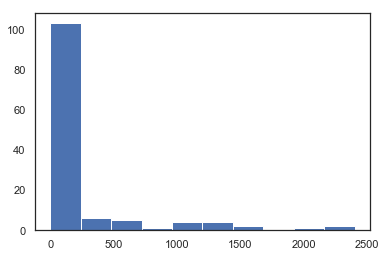

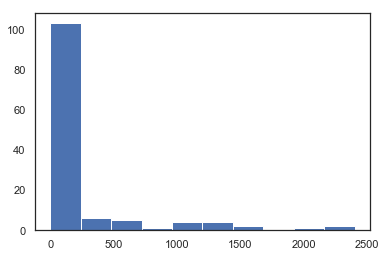

In [20]:
# Select sites with plenty of data:
plt.hist( (~pd.isnull(heatmap)).sum() )
plt.show()
df_selected = heatmap.loc[:, ((~pd.isnull(heatmap)).sum()>150) ]
plt.hist( (~pd.isnull(heatmap)).sum() )
plt.show()


In [21]:
## For the full dataset, not separated for each gastruloid yet
# define the total amount of scars
totalScars = set()
for i,r in df_targetsites.iterrows():
    totalScars.update( set( [x for x in r.unique() if not pd.isnull(x)]) )


In [22]:
## For the full dataset, not separated for each gastruloid yet
# define one colour for each scar
cmap = plt.get_cmap('hsv')
scarColors = { scar: cmap(x) for scar, x in zip(totalScars, np.linspace(0,1, len(totalScars))) }
scarColors['WT'] = (0,0,0)

In [23]:
# Determine organisation of the plot, based on site-allele with most information
df_targetsites = df_targetsites.sort_values([df_targetsites.columns[6],df_targetsites.columns[10],
                                            df_targetsites.columns[2],df_targetsites.columns[13],
                                            df_targetsites.columns[5],df_targetsites.columns[7]])


In [24]:
df_targetsites = df_targetsites[(~pd.isnull(df_targetsites)).sum(axis=1)>0]


In [ ]:
# to plot all sites for only 129 and B6 alleles, without nonallelic
df_targetsites2 = df_targetsites[['129, 114682729', 'B6, 114682729', 
                          '129, 114708745', 
                          '129, 114723869', 'B6, 114723869', 
                          'B6, 114740505', 
                          '129, 114746370', 'B6, 114746370', 
                          '129, 114788470', 'B6, 114788470', 
                          '129, 114851288', 
                          '129, 114879985', 
                          '129, 114896335']]


In [ ]:
#pathToSaveData = '/Users/m.blotenburg/Documents/github/scars_filteredDataPlots/'

In [25]:
def plotHeatmap(df, figsize = (15,50)):
    fig, ax = plt.subplots(1, figsize=figsize)
    columnsCount = df.shape[1]
    
    rowHeight = 1
    rowColwidth = 1
    rowSpacing = 0.3
    for cellIndex, (cellName, row) in enumerate(df.iterrows()):
        for columnIndex,column in enumerate(df.columns):
            scarForThisCell = row[column]
            if not pd.isnull(scarForThisCell):
                ax.add_patch(
                matplotlib.patches.Rectangle(
                    (rowColwidth*columnIndex,rowHeight*cellIndex ), 
                    rowColwidth, rowHeight-rowSpacing, color= scarColors[scarForThisCell])
            )

    ax.set_ylim(0,rowHeight*(df.shape[0]+1))
    ax.set_xlim(0,rowColwidth*(df.shape[1]))
    ax.set_xticks([columnIndex+0.5 for columnIndex,column in enumerate(df.columns)])
    ax.set_xticklabels([column for columnIndex,column in enumerate(df.columns)],rotation=90)
    ax.set_yticks([cellIndex+0.5 for cellIndex,cellName in enumerate(df.index)])
    ax.set_yticklabels([cellName for cellIndex,cellName in enumerate(df.index)],fontsize=6.5)

    return ax

To plot all sites, all gastruloids:

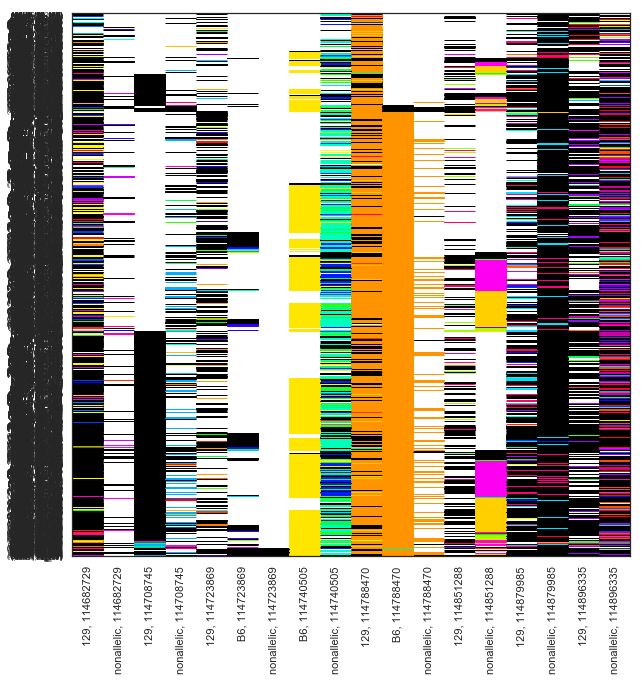

In [26]:
plotHeatmap(df_targetsites, (10,10))

Plotting heatmaps for individual gastruloids:

In [27]:
# to check which gastruloids are present in the dataset
heatmap.index.levels[0]

Index(['C5A9', 'C5B10', 'C5C6', 'C5F10', 'C5G7', 'C5H11', 'C5H7', 'C5H9'], dtype='object', name='gastruloid')

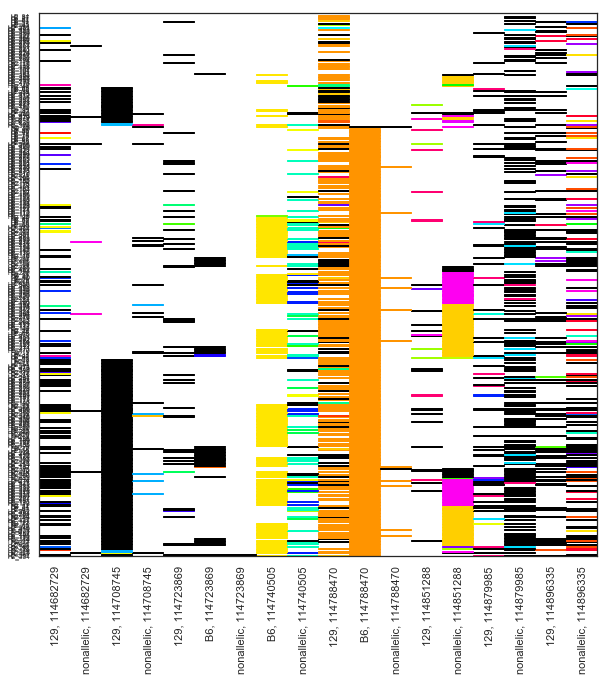

In [28]:
plotHeatmap(df_targetsites.loc['C5F10'], (10,10))

# Clustering using Information Weighted Sparse Sample Distance (IWSS)

In [ ]:
#to load dataframes for distance calculation again
all_allelecounts_fordistancecalc = pd.read_pickle(pathToData + '120hAA_all_allelecounts_fordistancecalc.pickle.gz')
allelecountsNA_ts = pd.read_pickle(pathToData + '120hAA_allelecountsNA_ts.pickle.gz')
allelecountsB6_ts = pd.read_pickle(pathToData + '120hAA_allelecountsB6_ts.pickle.gz')
allelecounts129_ts = pd.read_pickle(pathToData + '120hAA_allelecounts129_ts.pickle.gz')

In [ ]:
all_allelecounts_fordistancecalc.columns.levels[0]

In [ ]:
all_allelecounts = all_allelecounts_fordistancecalc.fillna(0).transpose()
# to check scars only, no WT counts
all_allelecounts_noWT = all_allelecounts[all_allelecounts.columns.drop(list(all_allelecounts.filter(regex='WT')))]

In [ ]:
def plotAllAlleleCounts(allelecounts, bins=20,color='black'):
    plt.figure(figsize=(8,4))
    allelecounts.sum(axis=1).plot.hist(grid=True, bins=bins, rwidth=0.95,color=color)
    plt.xlabel('Amount of counts per cell')
    plt.title('Amount of counts per cell')
    plt.ylabel('Number of cells')

In [ ]:
plotAllAlleleCounts(all_allelecounts)
plotAllAlleleCounts(all_allelecounts_noWT, bins=8,color='grey')

In [ ]:
plotAllAlleleCounts(all_allelecounts.loc['C5F10'], bins = 10)
plotAllAlleleCounts(all_allelecounts_noWT.loc['C5F10'], bins=8,color='grey')

In [ ]:
#this filters out cells with less than n counts
filtered_all_allelecounts = collections.defaultdict(dict)
for cell in all_allelecounts.index:
    if all_allelecounts.loc[cell].sum() > 2:
        filtered_all_allelecounts[cell] = all_allelecounts.loc[cell]
filtered_all_allelecountsPD = pd.DataFrame.from_dict(filtered_all_allelecounts).transpose()

filter_allelecountsC5A9 = filtered_all_allelecountsPD.loc['C5A9'].fillna(0)
filter_allelecountsC5B10 = filtered_all_allelecountsPD.loc['C5B10'].fillna(0)
filter_allelecountsC5C6 = filtered_all_allelecountsPD.loc['C5C6'].fillna(0)
filter_allelecountsC5F10 = filtered_all_allelecountsPD.loc['C5F10'].fillna(0)
filter_allelecountsC5G7 = filtered_all_allelecountsPD.loc['C5G7'].fillna(0)
filter_allelecountsC5H11 = filtered_all_allelecountsPD.loc['C5H11'].fillna(0)
filter_allelecountsC5H7 = filtered_all_allelecountsPD.loc['C5H7'].fillna(0)
filter_allelecountsC5H9 = filtered_all_allelecountsPD.loc['C5H9'].fillna(0)
filter_all_allelecounts = filtered_all_allelecountsPD.fillna(0).transpose()

# Distance matrix for all gastruloids

distanceMatrix automatically returns the figure of the clustering. In addition, when saying x = distanceMatrix(dataframe), it assigns the output (distance) matrix df to x. This can later be used for clustering the data into groups.

In [ ]:
def distanceMatrix(filteredDF,figsize=(15,15),heatmapTitle=''):
    rawMatrix = filteredDF.values 
    rawMatrix = rawMatrix[:, np.logical_and( 
        np.sum(rawMatrix==0,axis=0)>0,
        np.sum(rawMatrix==1,axis=0)>0)]
    pOnes = []
    pZeros = []
    for i in range(rawMatrix.shape[1]):
    # Weights:
        column = rawMatrix[:,i]
        pOnes.append( -np.log2( ( np.sum(column==1)/len(column) )**2 ) ) #probability of two cells both having sSNV
        pZeros.append( -np.log2( ( np.sum(column==0)/len(column) )**2 ) )#probability of two cells not having sSNV,  (and we know it)
    pOnes = np.array(pOnes)
    pZeros = np.array(pZeros)
    
    print( np.sum( np.logical_not(np.isfinite(pZeros)) ),  np.sum((np.isfinite(pZeros))))
    print( np.sum( np.logical_not(np.isfinite(pOnes)) ),  np.sum((np.isfinite(pOnes))))
    print(rawMatrix.shape)
    
    jointMatrix = np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )
    simMatrix =  np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )
    differenceMatrix =  np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )

    for cai in range(rawMatrix.shape[0]):
        for cbi in range(rawMatrix.shape[0]):
            
        
                # Un normalized distance
            pairwiseUnnormalizedDistance = np.logical_and( rawMatrix[cai,:]==1, rawMatrix[cbi,:]==0 ) * \
            (pOnes + pZeros) + \
            np.logical_and( rawMatrix[cai,:]==0, rawMatrix[cbi,:]==1 ) * (pZeros + pOnes) # For different batches the pOnes/pZeros is batch depended

                # Normalize the distance:
            normalisationFactor = np.sum( pOnes* (rawMatrix[cai,:]==1)) + np.sum( pZeros*(rawMatrix[cai,:]==0)) + \
            np.sum( pOnes* (rawMatrix[cbi,:]==1)) + np.sum( pZeros* (rawMatrix[cbi,:]==0))

            pairwiseNormalizedDistance = np.sum(pairwiseUnnormalizedDistance) / (
                        normalisationFactor )
            differenceMatrix[cai, cbi] = pairwiseNormalizedDistance

                # Similarity calculation:
            sim = np.sum( (pOnes+pOnes) * np.logical_and( rawMatrix[cai,:]==1, rawMatrix[cbi,:]==1 )) + \
                      np.sum( (pZeros+pZeros)*np.logical_and( rawMatrix[cai,:]==0, rawMatrix[cbi,:]==0 ))

            normalisedSim = sim/normalisationFactor
            simMatrix[cai, cbi] = normalisedSim

            joinedDistance =  pairwiseNormalizedDistance + (1-normalisedSim )
            jointMatrix[cai,cbi]= joinedDistance


            if cai==cbi:
                break

    normalisedSim, normalisationFactor, sim, rawMatrix[cai,rawMatrix[cai,:]>=0], rawMatrix[cbi,rawMatrix[cbi,:]>=0]
    print(np.where( np.logical_not( np.isfinite( jointMatrix ) ) ))
    #rawMatrix[ np.where( np.logical_not( np.isfinite( jointMatrix ) ) )[0][0] ]
    
    for i in range(jointMatrix.shape[0]):
        for j in range(jointMatrix.shape[0]):
            jointMatrix[j,i]=jointMatrix[i,j]
            if i==j:
                break

    df = pd.DataFrame( np.log(jointMatrix+1), index=filteredDF.index, columns=filteredDF.index )
    x = sns.clustermap( df, vmin=0,vmax=1, figsize=figsize, method='average',metric='euclidean')
    x.fig.suptitle(heatmapTitle)
    x.fig.subplots_adjust(top=0.93)
    #.savefig('heatmapC5F10.png',dpi=300)
    return df
    



## All gastruloids from dataset
 'C5A9', 'C5B10', 'C5C6', 'C5F10',  C5G7', 'C5H11', 'C5H7', 'C5H9'

In [ ]:
dmC5A9 = distanceMatrix(filter_allelecountsC5A9, figsize = (8,8), heatmapTitle='C5A9')

In [ ]:
dmC5B10 = distanceMatrix(filter_allelecountsC5B10, figsize = (8,8))

In [ ]:
dmC5C6 = distanceMatrix(filter_allelecountsC5C6, figsize = (8,8))

In [ ]:
dmC5F10 = distanceMatrix(filter_allelecountsC5F10, figsize = (8,8))

In [ ]:
dmC5G7 = distanceMatrix(filter_allelecountsC5G7, figsize = (8,8))

In [ ]:
dmC5H11 = distanceMatrix(filter_allelecountsC5H11, figsize = (8,8))

In [ ]:
dmC5H7 = distanceMatrix(filter_allelecountsC5H7, figsize = (8,8))

In [ ]:
dmC5H9 = distanceMatrix(filter_allelecountsC5H9, figsize = (8,8))

In [ ]:
all_allelecounts_fordistancecalc.columns.levels[0]

In [ ]:
for gastruloid in all_allelecounts_fordistancecalc.columns.levels[0]:
    filtered = filtered_all_allelecountsPD.loc[gastruloid].fillna(0)
    distanceMatrix(filtered, figsize = (8,8), heatmapTitle = gastruloid)

## Clustering based on computed distance matrix.

In [ ]:
def scipyClustering(df, gastruloidName = '', clusterNumber = 20):
    x = scipy.cluster.hierarchy.linkage(df.fillna(0),'ward')
    clusters = scipy.cluster.hierarchy.cut_tree(x, n_clusters= (clusterNumber))
    clust = pd.DataFrame.from_dict({cellName:{('clust_' + gastruloidName):clusters[cellIndex][0]} for cellIndex,cellName in enumerate(df.index)}).transpose()
    return clust

In [ ]:
C5F10_clust = scipyClustering(dmC5F10, gastruloidName = 'C5F10',  clusterNumber = (len(dmC5F10)/10))

In [ ]:
C5A9_clust = scipyClustering(dmC5A9, gastruloidName = 'C5A9',  clusterNumber = (len(dmC5A9)/10))

In [ ]:
C5B10_clust = scipyClustering(dmC5B10, gastruloidName = 'C5B10',  clusterNumber = (len(dmC5B10)/10))

In [ ]:
C5C6_clust = scipyClustering(dmC5C6, gastruloidName = 'C5C6',  clusterNumber = (len(dmC5C6)/10))

In [ ]:
C5G7_clust = scipyClustering(dmC5G7, gastruloidName = 'C5G7',  clusterNumber = (len(dmC5G7)/10))

In [ ]:
C5H11_clust = scipyClustering(dmC5H11, gastruloidName = 'C5H11',  clusterNumber = (len(dmC5H11)/10))

In [ ]:
C5H7_clust = scipyClustering(dmC5H7, gastruloidName = 'C5H7',  clusterNumber = (len(dmC5H7)/10))

In [ ]:
C5H9_clust = scipyClustering(dmC5H9, gastruloidName = 'C5H9',  clusterNumber = (len(dmC5H9)/10))

# For tsne plots

In [ ]:
tsne = read_csv('/Users/m.blotenburg/Documents/github/transcriptome_Datasets/tsneSTARmapped.txt', sep = '\t')
tsne.head()

In [ ]:
# format tsne dataframe
tsne2 = tsne.copy()
tsne2.index = tsne2.index.str.split('.', 1, expand=True)
tsne2 = tsne2.reset_index(level=1)
tsne2 = tsne2.rename(index=str, columns={"level_1": "gastruloid"})
tsne2.head()

In [ ]:
# add cluster information to tsne dataframe
dfs_all = [tsne2,C5F10_clust,C5A9_clust,C5B10_clust,C5C6_clust,C5G7_clust,C5H11_clust,C5H7_clust,C5H9_clust]
tsne_clust = dfs_all[0].join(dfs_all[1:],how='outer')
tsne_clust.tail()

In [ ]:
# save tsne with scar cluster information
tsne_clust.to_csv(pathToData + 'tsneSTARmapped_FilteredScarClusterInformation.csv')

In [ ]:
# print number of clusters for each gastruloid
print('Number of clusters for C5F10: ' + str(tsne_clust['clust_C5F10'].max()))
print('Number of clusters for C5A9: ' + str(tsne_clust['clust_C5A9'].max()))
print('Number of clusters for C5B10: ' + str(tsne_clust['clust_C5B10'].max()))
print('Number of clusters for C5C6: ' + str(tsne_clust['clust_C5C6'].max()))
print('Number of clusters for C5G7: ' + str(tsne_clust['clust_C5G7'].max()))
print('Number of clusters for C5H11: ' + str(tsne_clust['clust_C5H11'].max()))
print('Number of clusters for C5H7: ' + str(tsne_clust['clust_C5H7'].max()))
print('Number of clusters for C5H9: ' + str(tsne_clust['clust_C5H9'].max()))

In [ ]:
##### tsne with colours from raceid clusters
plt.figure(figsize=(10,10))
fig = sns.scatterplot(tsne['V1'], tsne['V2'], hue = tsne['scs.cpart'], palette=sns.color_palette("hls", 12))
#fig.figure.savefig(pathToSaveData + 'tsne_raceidClusters.png',dpi=300)

### For C5F10

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5F10']['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == 'C5F10']['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust['clust_C5F10'], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
plt.title('All scar clusters for gastruloid C5F10',fontsize=20)
#fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5F10_TsneAllScars.png', dpi=300)

In [ ]:
for clustnr in tsne_clust['clust_C5F10'].unique():
    if pd.isna(clustnr):
        continue
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5F10']['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == 'C5F10']['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = plt.scatter(tsne_clust[tsne_clust['clust_C5F10'] == clustnr]['V1'], 
                tsne_clust[tsne_clust['clust_C5F10'] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
    plt.title('Gastruloid C5F10, cluster ' + str(clustnr),fontsize=20)
    #fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5F10_tsneCluster'+ str(clustnr) + '.png', dpi=300)
    plt.show()
    #plt.close()
    

### More information on cluster 25 of gastruloid C5F10

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5F10']['V1'], 
                  tsne_clust[tsne_clust['gastruloid'] == 'C5F10']['V2'],
                  c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = plt.scatter(tsne_clust[tsne_clust['clust_C5F10'] == 25]['V1'], 
                  tsne_clust[tsne_clust['clust_C5F10'] == 25]['V2'],
                  c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
plt.title('Gastruloid C5F10, cluster ' + str(25),fontsize=20)
#fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5F10_tsneCluster'+ str(clustnr) + '.png', dpi=300)
plt.show()


In [ ]:
tsne_clust[tsne_clust['clust_C5F10'] == 25]

In [ ]:
tsne_clust[tsne_clust['clust_C5F10'] == 25].index

In [ ]:
df_targetsitesC5F10 = df_targetsites.loc['C5F10']
df_targetsitesC5F10.head()

In [ ]:
df_targetsitesC5F10clust25 = df_targetsitesC5F10.loc[['H2_168', 'H2_174', 'H2_249', 'H2_251', 'H2_310', 'H2_376', 'H2_38','H2_52', 'H2_55', 
                         'H2_70', 'H2_75', 'H2_86']]
df_targetsitesC5F10clust25

In [ ]:
# full C5F10 dataframe
fig, ax = plt.subplots(1, figsize=(15,20))
columnsCount = df_targetsitesC5F10.shape[1]

rowHeight = 1
rowColwidth = 1
rowSpacing = 0.3

for cellIndex, (cellName, row) in enumerate(df_targetsitesC5F10.iterrows()):
    for columnIndex,column in enumerate(df_targetsitesC5F10.columns):
        
        scarForThisCell = row[column]
        if not pd.isnull(scarForThisCell):
            ax.add_patch(
            matplotlib.patches.Rectangle(
                (rowColwidth*columnIndex,rowHeight*cellIndex ), 
                rowColwidth, rowHeight-rowSpacing, color= scarColors[scarForThisCell])
            )

ax.set_ylim(0,rowHeight*(df_targetsitesC5F10.shape[0]+1))
ax.set_xlim(0,rowColwidth*(df_targetsitesC5F10.shape[1]))

ax.set_xticks([columnIndex+0.5 for columnIndex,column in enumerate(df_targetsitesC5F10.columns)])
ax.set_xticklabels([column for columnIndex,column in enumerate(df_targetsitesC5F10.columns)],rotation=90, fontsize=20)

ax.set_yticks([cellIndex+0.5 for cellIndex,cellName in enumerate(df_targetsitesC5F10.index)])
ax.set_yticklabels([cellName for cellIndex,cellName in enumerate(df_targetsitesC5F10.index)],fontsize=6.5)

plt.show()

In [ ]:
# full C5F10 dataframe
fig, ax = plt.subplots(1, figsize=(10,5))
columnsCount = df_targetsitesC5F10clust25.shape[1]

rowHeight = 1
rowColwidth = 1
rowSpacing = 0.3

for cellIndex, (cellName, row) in enumerate(df_targetsitesC5F10clust25.iterrows()):
    for columnIndex,column in enumerate(df_targetsitesC5F10clust25.columns):
        
        scarForThisCell = row[column]
        if not pd.isnull(scarForThisCell):
            ax.add_patch(
            matplotlib.patches.Rectangle(
                (rowColwidth*columnIndex,rowHeight*cellIndex ), 
                rowColwidth, rowHeight-rowSpacing, color= scarColors[scarForThisCell])
            )

ax.set_ylim(0,rowHeight*(df_targetsitesC5F10clust25.shape[0]+1))
ax.set_xlim(0,rowColwidth*(df_targetsitesC5F10clust25.shape[1]))

ax.set_xticks([columnIndex+0.5 for columnIndex,column in enumerate(df_targetsitesC5F10clust25.columns)])
ax.set_xticklabels([column for columnIndex,column in enumerate(df_targetsitesC5F10clust25.columns)],rotation=90,fontsize=15)

ax.set_yticks([cellIndex+0.5 for cellIndex,cellName in enumerate(df_targetsitesC5F10clust25.index)])
ax.set_yticklabels([cellName for cellIndex,cellName in enumerate(df_targetsitesC5F10clust25.index)],fontsize=15)

plt.show()

In [ ]:
df_targetsitesC5F10clust25 = df_targetsitesC5F10.loc[['H2_127', 'H2_250', 'H2_303', 'H2_309', 'H2_4', 'H2_53']]
df_targetsitesC5F10clust25

# full C5F10 dataframe
fig, ax = plt.subplots(1, figsize=(10,5))
columnsCount = df_targetsitesC5F10clust25.shape[1]

rowHeight = 1
rowColwidth = 1
rowSpacing = 0.3

for cellIndex, (cellName, row) in enumerate(df_targetsitesC5F10clust25.iterrows()):
    for columnIndex,column in enumerate(df_targetsitesC5F10clust25.columns):
        
        scarForThisCell = row[column]
        if not pd.isnull(scarForThisCell):
            ax.add_patch(
            matplotlib.patches.Rectangle(
                (rowColwidth*columnIndex,rowHeight*cellIndex ), 
                rowColwidth, rowHeight-rowSpacing, color= scarColors[scarForThisCell])
            )

ax.set_ylim(0,rowHeight*(df_targetsitesC5F10clust25.shape[0]+1))
ax.set_xlim(0,rowColwidth*(df_targetsitesC5F10clust25.shape[1]))

ax.set_xticks([columnIndex+0.5 for columnIndex,column in enumerate(df_targetsitesC5F10clust25.columns)])
ax.set_xticklabels([column for columnIndex,column in enumerate(df_targetsitesC5F10clust25.columns)],rotation=90,fontsize=15)

ax.set_yticks([cellIndex+0.5 for cellIndex,cellName in enumerate(df_targetsitesC5F10clust25.index)])
ax.set_yticklabels([cellName for cellIndex,cellName in enumerate(df_targetsitesC5F10clust25.index)],fontsize=15)

plt.show()


### For C5A9

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5A9']['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == 'C5A9']['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust['clust_C5A9'], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
plt.title('All scar clusters for gastruloid C5A9',fontsize=20)
fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5A9_TsneAllScars.png', dpi=300)

In [ ]:
for clustnr in tsne_clust['clust_C5A9'].unique():
    if pd.isna(clustnr):
        continue
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5A9']['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == 'C5A9']['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = plt.scatter(tsne_clust[tsne_clust['clust_C5A9'] == clustnr]['V1'], 
                tsne_clust[tsne_clust['clust_C5A9'] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
    plt.title('Gastruloid C5A9, cluster ' + str(clustnr),fontsize=20)
    fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5A9_tsneCluster'+ str(clustnr) + '.png', dpi=300)
    #plt.show()
    plt.close()
    

### For C5B10

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5B10']['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == 'C5B10']['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust['clust_C5B10'], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
plt.title('All scar clusters for gastruloid C5B10',fontsize=20)
fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5B10_TsneAllScars.png', dpi=300)

In [ ]:
for clustnr in tsne_clust['clust_C5B10'].unique():
    if pd.isna(clustnr):
        continue
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5B10']['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == 'C5B10']['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = plt.scatter(tsne_clust[tsne_clust['clust_C5B10'] == clustnr]['V1'], 
                tsne_clust[tsne_clust['clust_C5B10'] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
    plt.title('Gastruloid C5B10, cluster ' + str(clustnr),fontsize=20)
    fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5B10_tsneCluster'+ str(clustnr) + '.png', dpi=300)
    #plt.show()
    plt.close()

### For C5C6

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5C6']['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == 'C5C6']['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust['clust_C5C6'], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
plt.title('All scar clusters for gastruloid C5C6',fontsize=20)
fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5C6_TsneAllScars.png', dpi=300)

In [ ]:
for clustnr in tsne_clust['clust_C5C6'].unique():
    if pd.isna(clustnr):
        continue
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5C6']['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == 'C5C6']['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = plt.scatter(tsne_clust[tsne_clust['clust_C5C6'] == clustnr]['V1'], 
                tsne_clust[tsne_clust['clust_C5C6'] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
    plt.title('Gastruloid C5C6, cluster ' + str(clustnr),fontsize=20)
    fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5C6_tsneCluster'+ str(clustnr) + '.png', dpi=300)
    #plt.show()
    plt.close()

### For C5G7

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5G7']['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == 'C5G7']['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust['clust_C5G7'], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
plt.title('All scar clusters for gastruloid C5G7',fontsize=20)
fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5G7_TsneAllScars.png', dpi=300)

In [ ]:
for clustnr in tsne_clust['clust_C5G7'].unique():
    if pd.isna(clustnr):
        continue
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5G7']['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == 'C5G7']['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = plt.scatter(tsne_clust[tsne_clust['clust_C5G7'] == clustnr]['V1'], 
                tsne_clust[tsne_clust['clust_C5G7'] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
    plt.title('Gastruloid C5G7, cluster ' + str(clustnr),fontsize=20)
    fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5G7_tsneCluster'+ str(clustnr) + '.png', dpi=300)
    #plt.show()
    plt.close()

### For C5H11

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5H11']['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == 'C5H11']['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust['clust_C5H11'], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
plt.title('All scar clusters for gastruloid C5H11',fontsize=20)
fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5H11_TsneAllScars.png', dpi=300)

In [ ]:
for clustnr in tsne_clust['clust_C5H11'].unique():
    if pd.isna(clustnr):
        continue
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5H11']['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == 'C5H11']['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = plt.scatter(tsne_clust[tsne_clust['clust_C5H11'] == clustnr]['V1'], 
                tsne_clust[tsne_clust['clust_C5H11'] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
    plt.title('Gastruloid C5H11, cluster ' + str(clustnr),fontsize=20)
    fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5H11_tsneCluster'+ str(clustnr) + '.png', dpi=300)
    #plt.show()
    plt.close()

### For C5H7

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5H7']['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == 'C5H7']['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust['clust_C5H7'], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
plt.title('All scar clusters for gastruloid C5H7',fontsize=20)
fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5H7_TsneAllScars.png', dpi=300)

In [ ]:
for clustnr in tsne_clust['clust_C5H7'].unique():
    if pd.isna(clustnr):
        continue
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5H7']['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == 'C5H7']['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = plt.scatter(tsne_clust[tsne_clust['clust_C5H7'] == clustnr]['V1'], 
                tsne_clust[tsne_clust['clust_C5H7'] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
    plt.title('Gastruloid C5H7, cluster ' + str(clustnr),fontsize=20)
    fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5H7_tsneCluster'+ str(clustnr) + '.png', dpi=300)
    #plt.show()
    plt.close()

### For C5H9

In [ ]:
plt.figure(figsize=(10,10))
fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5H9']['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == 'C5H9']['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust['clust_C5H9'], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
plt.title('All scar clusters for gastruloid C5H9',fontsize=20)
fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5H9_TsneAllScars.png', dpi=300)

In [ ]:
for clustnr in tsne_clust['clust_C5H9'].unique():
    if pd.isna(clustnr):
        continue
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == 'C5H9']['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == 'C5H9']['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = plt.scatter(tsne_clust[tsne_clust['clust_C5H9'] == clustnr]['V1'], 
                tsne_clust[tsne_clust['clust_C5H9'] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
    plt.title('Gastruloid C5H9, cluster ' + str(clustnr),fontsize=20)
    fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5H9_tsneCluster'+ str(clustnr) + '.png', dpi=300)
    #plt.show()
    plt.close()

# Colours

In [ ]:
cols=["black", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#006FA6", "#A30059", "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80","#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100", "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09","#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66","#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00","#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700","#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329","#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C","#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800","#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51","#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58","#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D","#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176","#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5","#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4","#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01","#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966","#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0","#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C","#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868","#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183","#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433","#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F","#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E","#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F","#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00","#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66","#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25","#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B", "#1E2324", "#DEC9B2", "#9D4948","#85ABB4", "#342142", "#D09685", "#A4ACAC", "#00FFFF", "#AE9C86", "#742A33", "#0E72C5","#AFD8EC", "#C064B9", "#91028C", "#FEEDBF", "#FFB789", "#9CB8E4", "#AFFFD1", "#2A364C","#4F4A43", "#647095", "#34BBFF", "#807781", "#920003", "#B3A5A7", "#018615", "#F1FFC8","#976F5C", "#FF3BC1", "#FF5F6B", "#077D84", "#F56D93", "#5771DA", "#4E1E2A", "#830055","#02D346", "#BE452D", "#00905E", "#BE0028", "#6E96E3", "#007699", "#FEC96D", "#9C6A7D","#3FA1B8", "#893DE3", "#79B4D6", "#7FD4D9", "#6751BB", "#B28D2D", "#E27A05", "#DD9CB8","#AABC7A", "#980034", "#561A02", "#8F7F00", "#635000", "#CD7DAE", "#8A5E2D", "#FFB3E1","#6B6466", "#C6D300", "#0100E2", "#88EC69", "#8FCCBE", "#21001C", "#511F4D", "#E3F6E3","#FF8EB1", "#6B4F29", "#A37F46", "#6A5950", "#1F2A1A", "#04784D", "#101835", "#E6E0D0","#FF74FE", "#00A45F", "#8F5DF8", "#4B0059", "#412F23", "#D8939E", "#DB9D72", "#604143","#B5BACE", "#989EB7", "#D2C4DB", "#A587AF", "#77D796", "#7F8C94", "#FF9B03", "#555196","#31DDAE", "#74B671", "#802647", "#2A373F", "#014A68", "#696628", "#4C7B6D", "#002C27","#7A4522", "#3B5859", "#E5D381", "#FFF3FF", "#679FA0", "#261300", "#2C5742", "#9131AF","#AF5D88", "#C7706A", "#61AB1F", "#8CF2D4", "#C5D9B8", "#9FFFFB", "#BF45CC", "#493941","#863B60", "#B90076", "#003177", "#C582D2", "#C1B394", "#602B70", "#887868", "#BABFB0","#030012", "#D1ACFE", "#7FDEFE", "#4B5C71", "#A3A097", "#E66D53", "#637B5D", "#92BEA5","#00F8B3", "#BEDDFF", "#3DB5A7", "#DD3248", "#B6E4DE", "#427745", "#598C5A", "#B94C59","#8181D5", "#94888B", "#FED6BD", "#536D31", "#6EFF92", "#E4E8FF", "#20E200", "#FFD0F2","#4C83A1", "#BD7322", "#915C4E", "#8C4787", "#025117", "#A2AA45", "#2D1B21", "#A9DDB0","#FF4F78", "#528500", "#009A2E", "#17FCE4", "#71555A", "#525D82", "#00195A", "#967874","#555558", "#0B212C", "#1E202B", "#EFBFC4", "#6F9755", "#6F7586", "#501D1D", "#372D00","#741D16", "#5EB393", "#B5B400", "#DD4A38", "#363DFF", "#AD6552", "#6635AF", "#836BBA","#98AA7F", "#464836", "#322C3E", "#7CB9BA", "#5B6965", "#707D3D", "#7A001D", "#6E4636","#443A38", "#AE81FF", "#489079", "#897334", "#009087", "#DA713C", "#361618", "#FF6F01","#006679", "#370E77", "#4B3A83", "#C9E2E6", "#C44170", "#FF4526", "#73BE54", "#C4DF72","#ADFF60", "#00447D", "#DCCEC9", "#BD9479", "#656E5B", "#EC5200", "#FF6EC2", "#7A617E","#DDAEA2", "#77837F", "#A53327", "#608EFF", "#B599D7", "#A50149", "#4E0025", "#C9B1A9","#03919A", "#1B2A25", "#E500F1", "#982E0B", "#B67180", "#E05859", "#006039", "#578F9B","#305230", "#CE934C", "#B3C2BE", "#C0BAC0", "#B506D3", "#170C10", "#4C534F", "#224451","#3E4141", "#78726D", "#B6602B", "#200441", "#DDB588", "#497200", "#C5AAB6", "#033C61","#71B2F5", "#A9E088", "#4979B0", "#A2C3DF", "#784149", "#2D2B17", "#3E0E2F", "#57344C","#0091BE", "#E451D1", "#4B4B6A", "#5C011A", "#7C8060", "#FF9491", "#4C325D", "#005C8B","#E5FDA4", "#68D1B6", "#032641", "#140023", "#8683A9", "#CFFF00", "#A72C3E", "#34475A","#B1BB9A", "#B4A04F", "#8D918E", "#A168A6", "#813D3A", "#425218", "#DA8386", "#776133","#563930", "#8498AE", "#90C1D3", "#B5666B", "#9B585E", "#856465", "#AD7C90", "#E2BC00","#E3AAE0", "#B2C2FE", "#FD0039", "#009B75", "#FFF46D", "#E87EAC", "#DFE3E6", "#848590","#AA9297", "#83A193", "#577977", "#3E7158", "#C64289", "#EA0072", "#C4A8CB", "#55C899","#E78FCF", "#004547", "#F6E2E3", "#966716", "#378FDB", "#435E6A", "#DA0004", "#1B000F","#5B9C8F", "#6E2B52", "#011115", "#E3E8C4", "#AE3B85", "#EA1CA9", "#FF9E6B", "#457D8B","#92678B", "#00CDBB", "#9CCC04", "#002E38", "#96C57F", "#CFF6B4", "#492818", "#766E52","#20370E", "#E3D19F", "#2E3C30", "#B2EACE", "#F3BDA4", "#A24E3D", "#976FD9", "#8C9FA8","#7C2B73", "#4E5F37", "#5D5462", "#90956F", "#6AA776", "#DBCBF6", "#DA71FF", "#987C95","#52323C", "#BB3C42", "#584D39", "#4FC15F", "#A2B9C1", "#79DB21", "#1D5958", "#BD744E","#160B00", "#20221A", "#6B8295", "#00E0E4", "#102401", "#1B782A", "#DAA9B5", "#B0415D","#859253", "#97A094", "#06E3C4", "#47688C", "#7C6755", "#075C00", "#7560D5", "#7D9F00","#C36D96", "#4D913E", "#5F4276", "#FCE4C8", "#303052", "#4F381B", "#E5A532", "#706690","#AA9A92", "#237363", "#73013E", "#FF9079", "#A79A74", "#029BDB", "#FF0169", "#C7D2E7","#CA8869", "#80FFCD", "#BB1F69", "#90B0AB", "#7D74A9", "#FCC7DB", "#99375B", "#00AB4D","#ABAED1", "#BE9D91", "#E6E5A7", "#332C22", "#DD587B", "#F5FFF7", "#5D3033", "#6D3800","#FF0020", "#B57BB3", "#D7FFE6", "#C535A9", "#260009", "#6A8781", "#A8ABB4", "#D45262","#794B61", "#4621B2", "#8DA4DB", "#C7C890", "#6FE9AD", "#A243A7", "#B2B081", "#181B00","#286154", "#4CA43B", "#6A9573", "#A8441D", "#5C727B", "#738671", "#D0CFCB", "#897B77","#1F3F22", "#4145A7", "#DA9894", "#A1757A", "#63243C", "#ADAAFF", "#00CDE2", "#DDBC62","#698EB1", "#208462", "#00B7E0", "#614A44", "#9BBB57", "#7A5C54", "#857A50", "#766B7E","#014833", "#FF8347", "#7A8EBA", "#274740", "#946444", "#EBD8E6", "#646241", "#373917","#6AD450", "#81817B", "#D499E3", "#979440", "#011A12", "#526554", "#B5885C", "#A499A5","#03AD89", "#B3008B", "#E3C4B5", "#96531F", "#867175", "#74569E", "#617D9F", "#E70452","#067EAF", "#A697B6", "#B787A8", "#9CFF93", "#311D19", "#3A9459", "#6E746E", "#B0C5AE","#84EDF7", "#ED3488", "#754C78", "#384644", "#C7847B", "#00B6C5", "#7FA670", "#C1AF9E","#2A7FFF", "#72A58C", "#FFC07F", "#9DEBDD", "#D97C8E", "#7E7C93", "#62E674", "#B5639E","#FFA861", "#C2A580", "#8D9C83", "#B70546", "#372B2E", "#0098FF", "#985975", "#20204C","#FF6C60", "#445083", "#8502AA", "#72361F", "#9676A3", "#484449", "#CED6C2", "#3B164A","#CCA763", "#2C7F77", "#02227B", "#A37E6F", "#CDE6DC", "#CDFFFB", "#BE811A", "#F77183","#EDE6E2", "#CDC6B4", "#FFE09E", "#3A7271", "#FF7B59", "#4E4E01", "#4AC684", "#8BC891","#BC8A96", "#CF6353", "#DCDE5C", "#5EAADD", "#F6A0AD", "#E269AA", "#A3DAE4", "#436E83","#002E17", "#ECFBFF", "#A1C2B6", "#50003F", "#71695B", "#67C4BB", "#536EFF", "#5D5A48","#890039", "#969381", "#371521", "#5E4665", "#AA62C3", "#8D6F81", "#2C6135", "#410601","#564620", "#E69034", "#6DA6BD", "#E58E56", "#E3A68B", "#48B176", "#D27D67", "#B5B268","#7F8427", "#FF84E6", "#435740", "#EAE408", "#F4F5FF", "#325800", "#4B6BA5", "#ADCEFF","#9B8ACC", "#885138", "#5875C1", "#7E7311", "#FEA5CA", "#9F8B5B", "#A55B54", "#89006A","#AF756F", "#2A2000", "#7499A1", "#FFB550", "#00011E", "#D1511C", "#688151", "#BC908A","#78C8EB", "#8502FF", "#483D30", "#C42221", "#5EA7FF", "#785715", "#0CEA91", "#FFFAED","#B3AF9D", "#3E3D52", "#5A9BC2", "#9C2F90", "#8D5700", "#ADD79C", "#00768B", "#337D00","#C59700", "#3156DC", "#944575", "#ECFFDC", "#D24CB2", "#97703C", "#4C257F", "#9E0366","#88FFEC", "#B56481", "#396D2B", "#56735F", "#988376", "#9BB195", "#A9795C", "#E4C5D3","#9F4F67", "#1E2B39", "#664327", "#AFCE78", "#322EDF", "#86B487", "#C23000", "#ABE86B","#96656D", "#250E35", "#A60019", "#0080CF", "#CAEFFF", "#323F61", "#A449DC", "#6A9D3B","#FF5AE4", "#636A01", "#D16CDA", "#736060", "#FFBAAD", "#D369B4", "#FFDED6", "#6C6D74","#927D5E", "#845D70", "#5B62C1", "#2F4A36", "#E45F35", "#FF3B53", "#AC84DD", "#762988","#70EC98", "#408543", "#2C3533", "#2E182D", "#323925", "#19181B", "#2F2E2C", "#023C32","#9B9EE2", "#58AFAD", "#5C424D", "#7AC5A6", "#685D75", "#B9BCBD", "#834357", "#1A7B42","#2E57AA", "#E55199", "#316E47", "#CD00C5", "#6A004D", "#7FBBEC", "#F35691", "#D7C54A","#62ACB7", "#CBA1BC", "#A28A9A", "#6C3F3B", "#FFE47D", "#DCBAE3", "#5F816D", "#3A404A","#7DBF32", "#E6ECDC", "#852C19", "#285366", "#B8CB9C", "#0E0D00", "#4B5D56", "#6B543F","#E27172", "#0568EC", "#2EB500", "#D21656", "#EFAFFF", "#682021", "#2D2011", "#DA4CFF","#70968E", "#FF7B7D", "#4A1930", "#E8C282", "#E7DBBC", "#A68486", "#1F263C", "#36574E","#52CE79", "#ADAAA9", "#8A9F45", "#6542D2", "#00FB8C", "#5D697B", "#CCD27F", "#94A5A1","#790229", "#E383E6", "#7EA4C1", "#4E4452", "#4B2C00", "#620B70", "#314C1E", "#874AA6","#E30091", "#66460A", "#EB9A8B", "#EAC3A3", "#98EAB3", "#AB9180", "#B8552F", "#1A2B2F","#94DDC5", "#9D8C76", "#9C8333", "#94A9C9", "#392935", "#8C675E", "#CCE93A", "#917100","#01400B", "#449896", "#1CA370", "#E08DA7", "#8B4A4E", "#667776", "#4692AD", "#67BDA8","#69255C", "#D3BFFF", "#4A5132", "#7E9285", "#77733C", "#E7A0CC", "#51A288", "#2C656A","#4D5C5E", "#C9403A", "#DDD7F3", "#005844", "#B4A200", "#488F69", "#858182", "#D4E9B9","#3D7397", "#CAE8CE", "#D60034", "#AA6746", "#9E5585", "#BA6200"]